**Importing Libraries**

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.6 MB/s eta 0:00:0000:0100:01


In [2]:
!pip install "pystan<3.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 836.3 kB/s eta 0:00:0000:0100:03


In [13]:
!pip install holidays==0.24

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.9/499.9 kB 6.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: holidays
    Found existing installation: holidays 0.27.1
    Uninstalling holidays-0.27.1:
      Successfully uninstalled holidays-0.27.1


In [16]:
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 5.8 MB/s eta 0:00:0000:0100:01m
  Using cached holidays-0.27.1-py3-none-any.whl (598 kB)
  Attempting uninstall: holidays
    Found existing installation: holidays 0.24
    Uninstalling holidays-0.24:
      Successfully uninstalled holidays-0.24


In [5]:
!pip install openpyxl

In [6]:
!pip install ephem

In [7]:
!pip install seaborn

In [43]:
pip install MiniSom

  Preparing metadata (setup.py) ... done
  Created wheel for MiniSom: filename=MiniSom-2.3.1-py3-none-any.whl size=10608 sha256=976091175d8d4408f454b24aca09b1d4c862700a70a50076a1a627904d4f4c59
  Stored in directory: /root/.cache/pip/wheels/e9/b8/0d/c949c0eb7a26af8926adcf3953a15dee78668f9af2261b2ac4
Successfully built MiniSom
Note: you may need to restart the kernel to use updated packages.


In [48]:
pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 5.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
import datetime
import matplotlib.dates as mdates
from cycler import cycler
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import math
from tslearn.clustering import TimeSeriesKMeans
from minisom import MiniSom
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tools.eval_measures import rmse
from scipy import signal
from scipy.stats import jarque_bera as jb
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from prophet import Prophet
import os
import warnings
warnings.filterwarnings('ignore')

**Importing Data**

In [23]:
retail_data=pd.read_csv("files/sales_train_evaluation.csv")
calender=pd.read_csv("files/calendar.csv")
sell_prices=pd.read_csv("files/sell_prices.csv")

In [24]:
rd_ca=retail_data[retail_data["state_id"]=="TX"].copy()
print("Missing Values:" +str(rd_ca.isna().sum().sum()))
rd_ca.head(5)

Missing Values:0


id        item_id    dept_id   cat_id  \
12196  HOBBIES_1_001_TX_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
12197  HOBBIES_1_002_TX_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
12198  HOBBIES_1_003_TX_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
12199  HOBBIES_1_004_TX_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
12200  HOBBIES_1_005_TX_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  \
12196     TX_1       TX    0    0    0    0  ...       0       0       0   
12197     TX_1       TX    0    0    0    0  ...       0       0       0   
12198     TX_1       TX    0    0    0    0  ...       0       0       0   
12199     TX_1       TX    1    2    1    0  ...       0       0       0   
12200     TX_1       TX    0    0    0    0  ...       0       0       1   

       d_1935  d_1936  d_1937  d_1938  d_1939  d_1940  d_1941  
12196       2       1       0       2       1       0       1  
12197       0       0       0       1       0       0       0  
12198       0       0       0       0       0       0       0  
12199       0       4       0       0       2       4       2  
12200       0       3       1       1       0       0       1  

[5 rows x 1947 columns]

In [25]:
sell_prices=sell_prices[sell_prices["store_id"].isin(["TX_1","TX_2","TX_3"])]
print("Missing Values: "+ str(sell_prices.isna().sum().sum()))
sell_prices.head(5)

Missing Values: 0


store_id        item_id  wm_yr_wk  sell_price
2708822     TX_1  HOBBIES_1_001     11325        9.58
2708823     TX_1  HOBBIES_1_001     11326        8.26
2708824     TX_1  HOBBIES_1_001     11327        8.26
2708825     TX_1  HOBBIES_1_001     11328        8.26
2708826     TX_1  HOBBIES_1_001     11329        8.26

In [26]:
rd_ca_melted=rd_ca.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
rd_ca_melted.rename({"variable":"Day","value":"Quantity"},axis=1,inplace=True)
rd_ca_melted.head(5)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_TX_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     TX_1   
1  HOBBIES_1_002_TX_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     TX_1   
2  HOBBIES_1_003_TX_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     TX_1   
3  HOBBIES_1_004_TX_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     TX_1   
4  HOBBIES_1_005_TX_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     TX_1   

  state_id  Day  Quantity  
0       TX  d_1         0  
1       TX  d_1         0  
2       TX  d_1         0  
3       TX  d_1         1  
4       TX  d_1         0

In [27]:
ca_joined=pd.merge(calender,rd_ca_melted,how="right",left_on=("d"),right_on="Day")
ca_joined=pd.merge(ca_joined,sell_prices,how="left",on=["store_id","item_id","wm_yr_wk"])
ca_joined.head(10)

date  wm_yr_wk   weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
1  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
2  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
3  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
4  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
5  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
6  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
7  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
8  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
9  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   

  event_type_1 event_name_2  ... snap_WI                             id  \
0          NaN          NaN  ...       0  HOBBIES_1_001_TX_1_evaluation   
1          NaN          NaN  ...       0  HOBBIES_1_002_TX_1_evaluation   
2          NaN          NaN  ...       0  HOBBIES_1_003_TX_1_evaluation   
3          NaN          NaN  ...       0  HOBBIES_1_004_TX_1_evaluation   
4          NaN          NaN  ...       0  HOBBIES_1_005_TX_1_evaluation   
5          NaN          NaN  ...       0  HOBBIES_1_006_TX_1_evaluation   
6          NaN          NaN  ...       0  HOBBIES_1_007_TX_1_evaluation   
7          NaN          NaN  ...       0  HOBBIES_1_008_TX_1_evaluation   
8          NaN          NaN  ...       0  HOBBIES_1_009_TX_1_evaluation   
9          NaN          NaN  ...       0  HOBBIES_1_010_TX_1_evaluation   

         item_id    dept_id   cat_id store_id state_id  Day Quantity  \
0  HOBBIES_1_001  HOBBIES_1  HOBBIES     TX_1       TX  d_1        0   
1  HOBBIES_1_002  HOBBIES_1  HOBBIES     TX_1       TX  d_1        0   
2  HOBBIES_1_003  HOBBIES_1  HOBBIES     TX_1       TX  d_1        0   
3  HOBBIES_1_004  HOBBIES_1  HOBBIES     TX_1       TX  d_1        1   
4  HOBBIES_1_005  HOBBIES_1  HOBBIES     TX_1       TX  d_1        0   
5  HOBBIES_1_006  HOBBIES_1  HOBBIES     TX_1       TX  d_1        0   
6  HOBBIES_1_007  HOBBIES_1  HOBBIES     TX_1       TX  d_1        0   
7  HOBBIES_1_008  HOBBIES_1  HOBBIES     TX_1       TX  d_1        4   
8  HOBBIES_1_009  HOBBIES_1  HOBBIES     TX_1       TX  d_1        3   
9  HOBBIES_1_010  HOBBIES_1  HOBBIES     TX_1       TX  d_1        0   

  sell_price  
0        NaN  
1        NaN  
2        NaN  
3       4.34  
4        NaN  
5        NaN  
6        NaN  
7       0.46  
8       1.56  
9       3.17  

[10 rows x 23 columns]

In [28]:
ca_joined.drop(["snap_CA","snap_WI"],axis=1,inplace=True)
ca_joined["total_sales"]=ca_joined["Quantity"]*ca_joined["sell_price"]

In [29]:
CA_store_daily=ca_joined.groupby(["store_id","date"],as_index=False).agg(Total_sales=("total_sales","sum"))
CA_store_daily["date"]=pd.to_datetime(CA_store_daily["date"])
CA_combined=CA_store_daily.pivot(index="date",columns="store_id",values="Total_sales")
CA1,CA2,CA3=[CA_store_daily[CA_store_daily["store_id"]==i].copy() for i in ["TX_1","TX_2","TX_3"]]
CA1.info()
CA_combined.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 1941 entries, 0 to 1940

Data columns (total 3 columns):

 #   Column       Non-Null Count  Dtype         

---  ------       --------------  -----         

 0   store_id     1941 non-null   object        

 1   date         1941 non-null   datetime64[ns]

 2   Total_sales  1941 non-null   float64       

dtypes: datetime64[ns](1), float64(1), object(1)

memory usage: 60.7+ KB

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 1941 entries, 2011-01-29 to 2016-05-22

Data columns (total 3 columns):

 #   Column  Non-Null Count  Dtype  

---  ------  --------------  -----  

 0   TX_1    1941 non-null   float64

 1   TX_2    1941 non-null   float64

 2   TX_3    1941 non-null   float64

dtypes: float64(3)

memory usage: 60.7 KB


In [30]:
for i in [CA1,CA2,CA3]:
    i.set_index("date",inplace=True)
    i.index.freq="D"

In [31]:
CA_monthly=CA_combined.resample("MS").sum()
CA_monthly_ind=[]
for i in [CA1,CA2,CA3]:
    CA_monthly_ind.append(i["Total_sales"].resample("MS").sum())
CA_monthly_long=CA_store_daily.set_index("date").groupby(["store_id"])["Total_sales"].resample("MS").sum().reset_index()

Text(0.5, 1.0, 'Monthly Sale From Jan-2011 to May-2016')

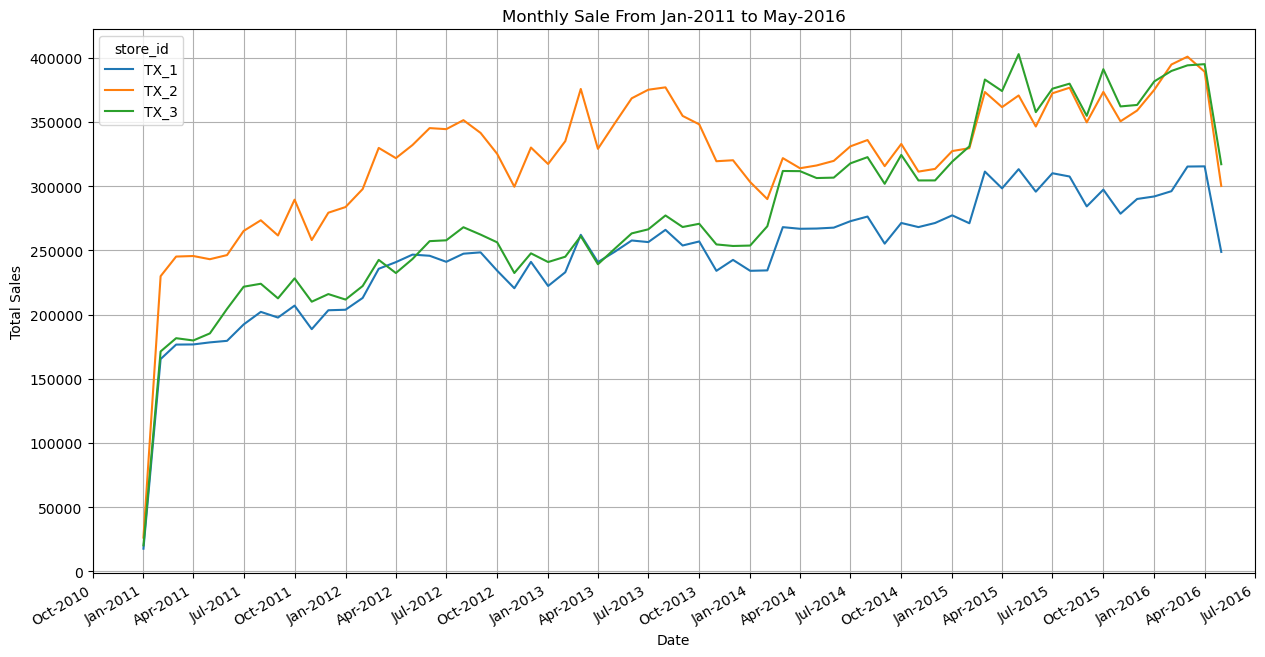

In [32]:
CA_monthly.plot(legend=True,
                figsize=(15,8),
                xlim=[datetime.datetime(2010,10,1),datetime.datetime(2016,7,1)],
                grid=True,
                ylabel="Total Sales",
                xlabel="Date",
                x_compat=True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.set_title("Monthly Sale From Jan-2011 to May-2016")

In [33]:
for i in range(3):
    CA_monthly_ind[i]=CA_monthly_ind[i].loc["02-2011":"04-2016"].copy()
CA_monthly=CA_monthly.loc["02-2011":"04-2016"].copy()
CA_monthly_long=CA_monthly_long.set_index("date").loc["02-2011":"04-2016"]

In [34]:
CA_monthly.to_excel("CA__monthly.xlsx")
for j,i in enumerate(CA_monthly_ind):
    i.to_excel("CA_"+str(j+1)+".xlsx")
CA_monthly_long.to_excel("CA__monthly_long.xlsx")

In [35]:
print("Length of the full dataset:"+str(len(CA_monthly.index.unique())))

Length of the full dataset:63


In [25]:
inputExcelFile ="files/CA_1.xlsx"
excelFile = pd.read_excel (inputExcelFile)
excelFile.to_csv ("files/CA_1.csv", index = None, header=True)

In [26]:
inputExcelFile ="files/CA_2.xlsx"
excelFile = pd.read_excel (inputExcelFile)
excelFile.to_csv ("files/CA_2.csv", index = None, header=True)

In [27]:
inputExcelFile ="files/CA_3.xlsx"
excelFile = pd.read_excel (inputExcelFile)
excelFile.to_csv ("files/CA_3.csv", index = None, header=True)

In [34]:
directory = "files/"

mySeries = []
namesofMySeries = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(directory+filename)
        df = df.loc[:,["date","Total_sales"]]
        df.set_index("date",inplace=True)
        df.sort_index(inplace=True)
        mySeries.append(df)
        namesofMySeries.append(filename[:-4])

In [35]:
print(len(mySeries))

3


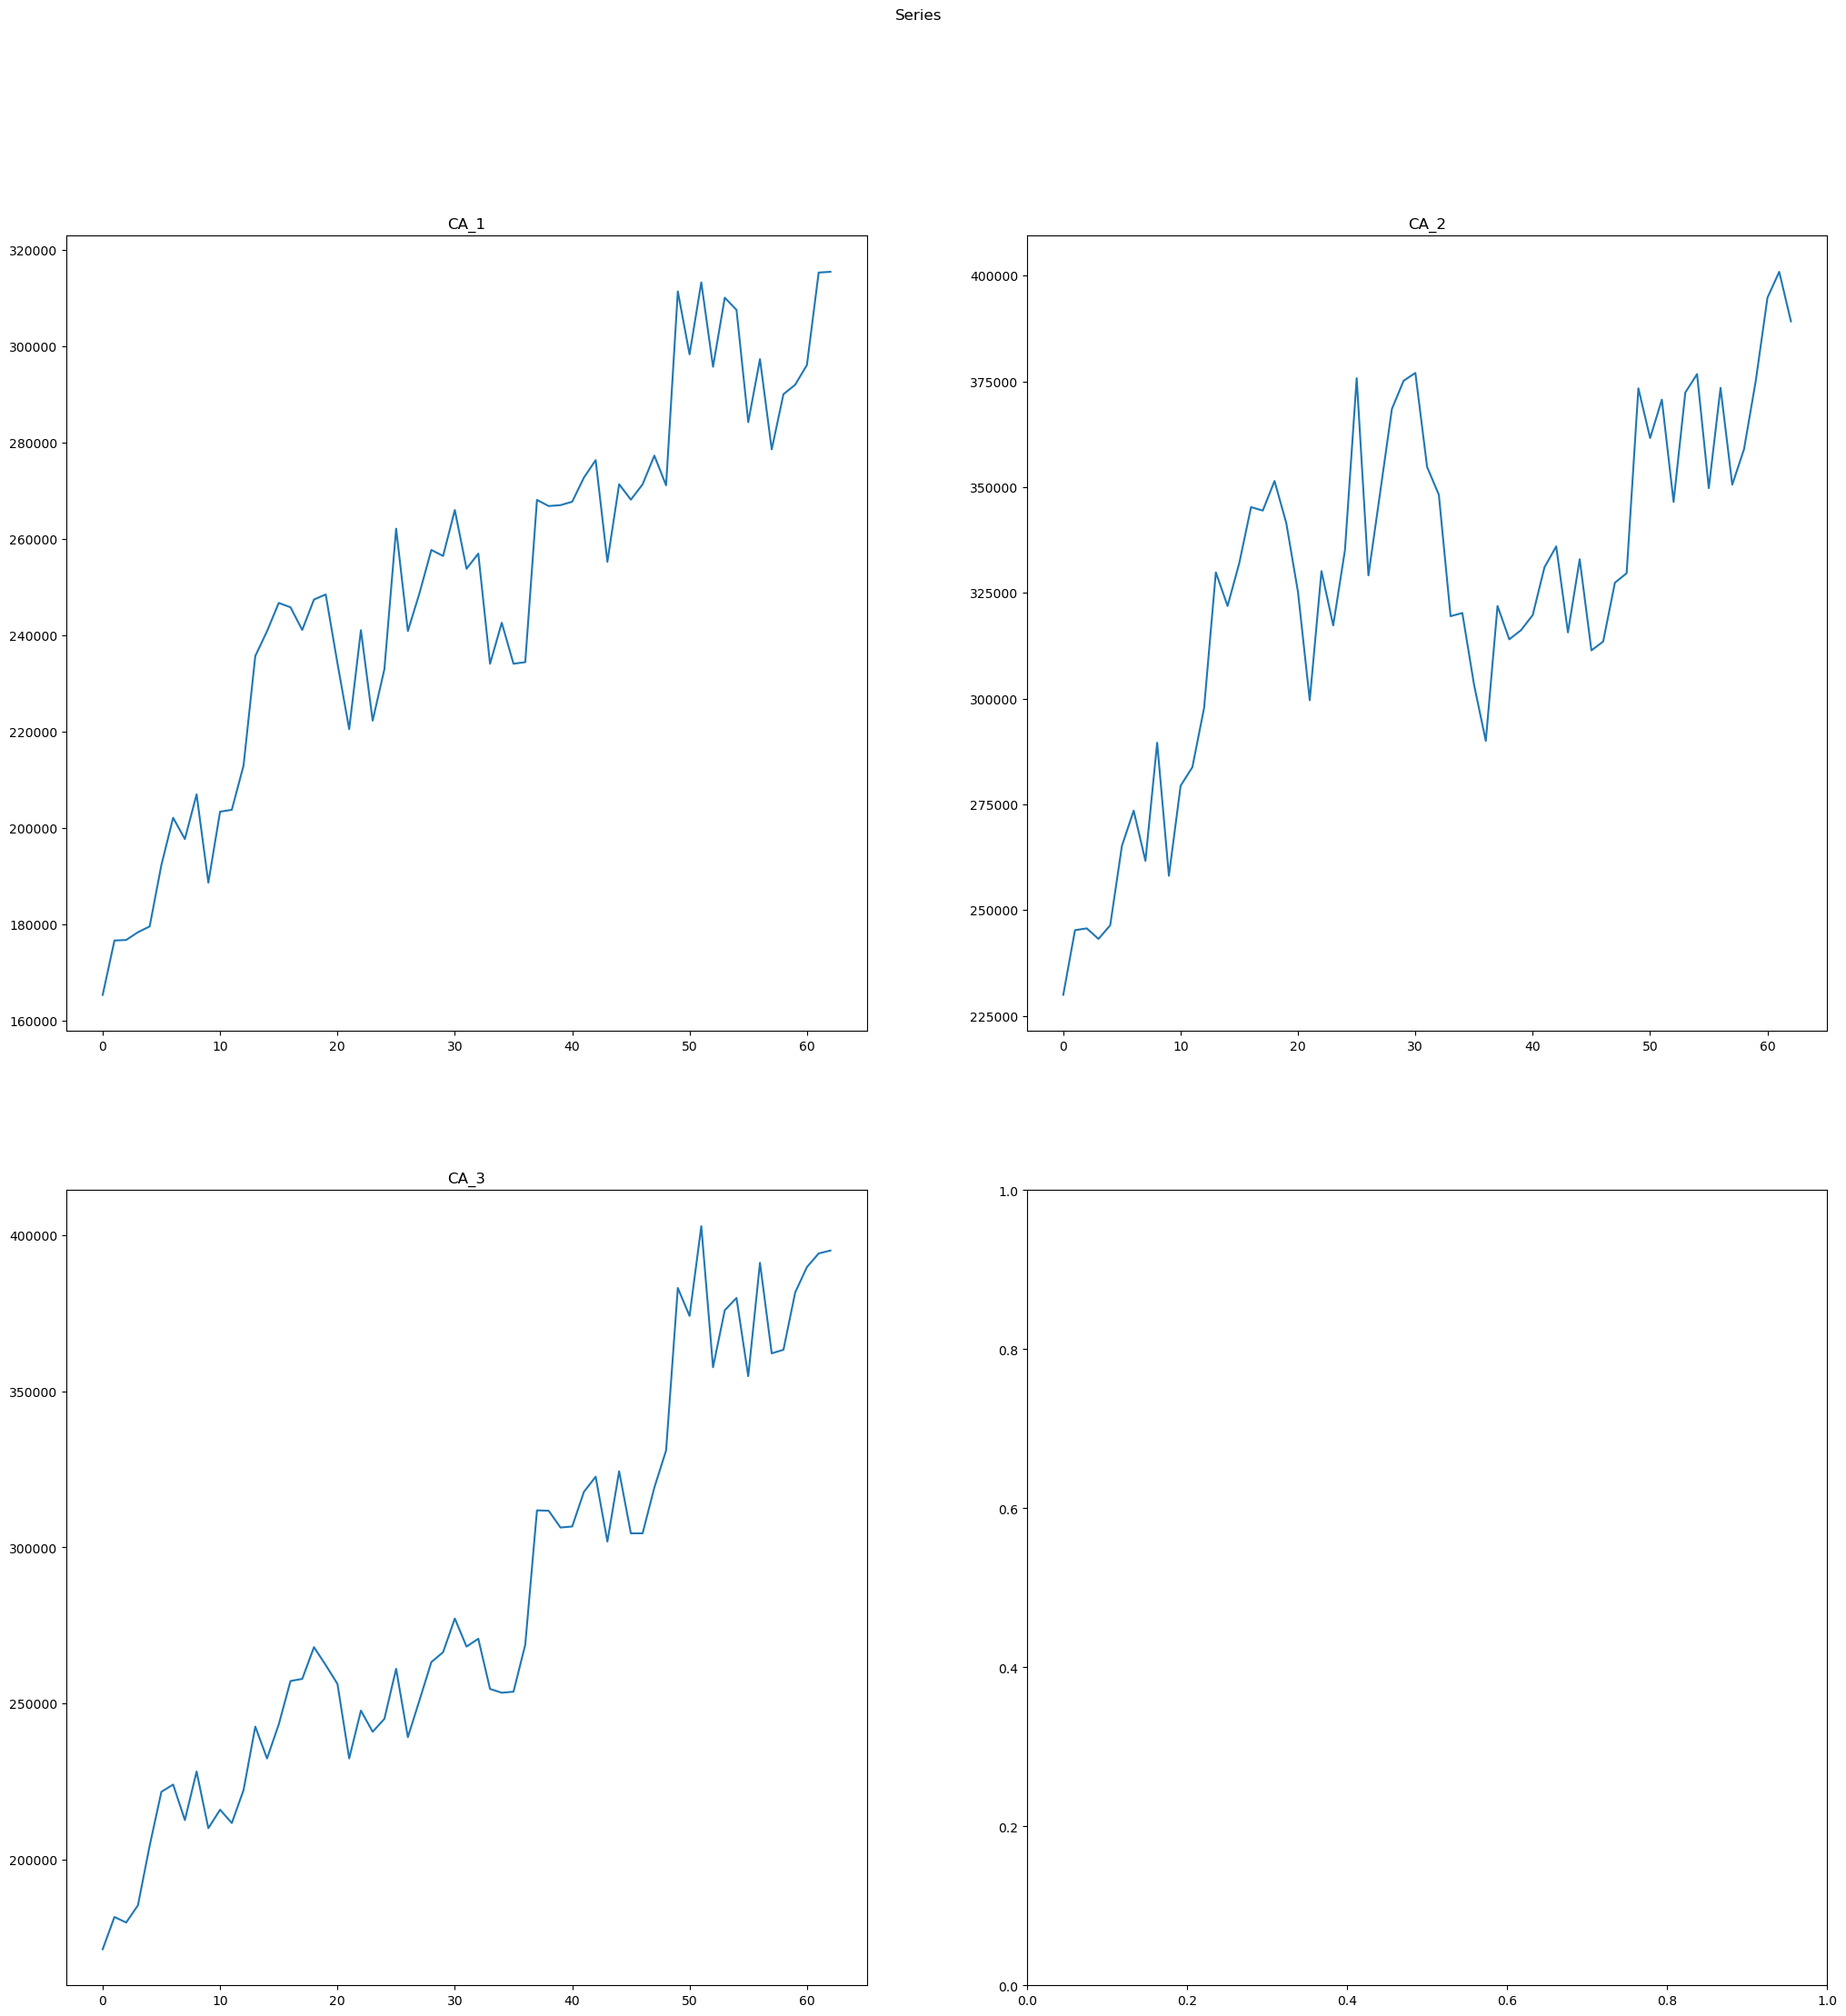

In [36]:
fig, axs = plt.subplots(2,2,figsize=(25,25))
fig.suptitle('Series')
for i in range(2):
    for j in range(2):
        if i*2+j+1>len(mySeries): 
            continue
        axs[i, j].plot(mySeries[i*2+j].values)
        axs[i, j].set_title(namesofMySeries[i*2+j])
plt.show()

In [37]:
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{63}


In [38]:
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

In [39]:
print("max: "+str(max(mySeries[0]))+"\tmin: "+str(min(mySeries[0])))
print(mySeries[0][:5])

max: 1.0000000000000002	min: 0.0
[0.         0.07511852 0.07588482 0.08656607 0.09457793]


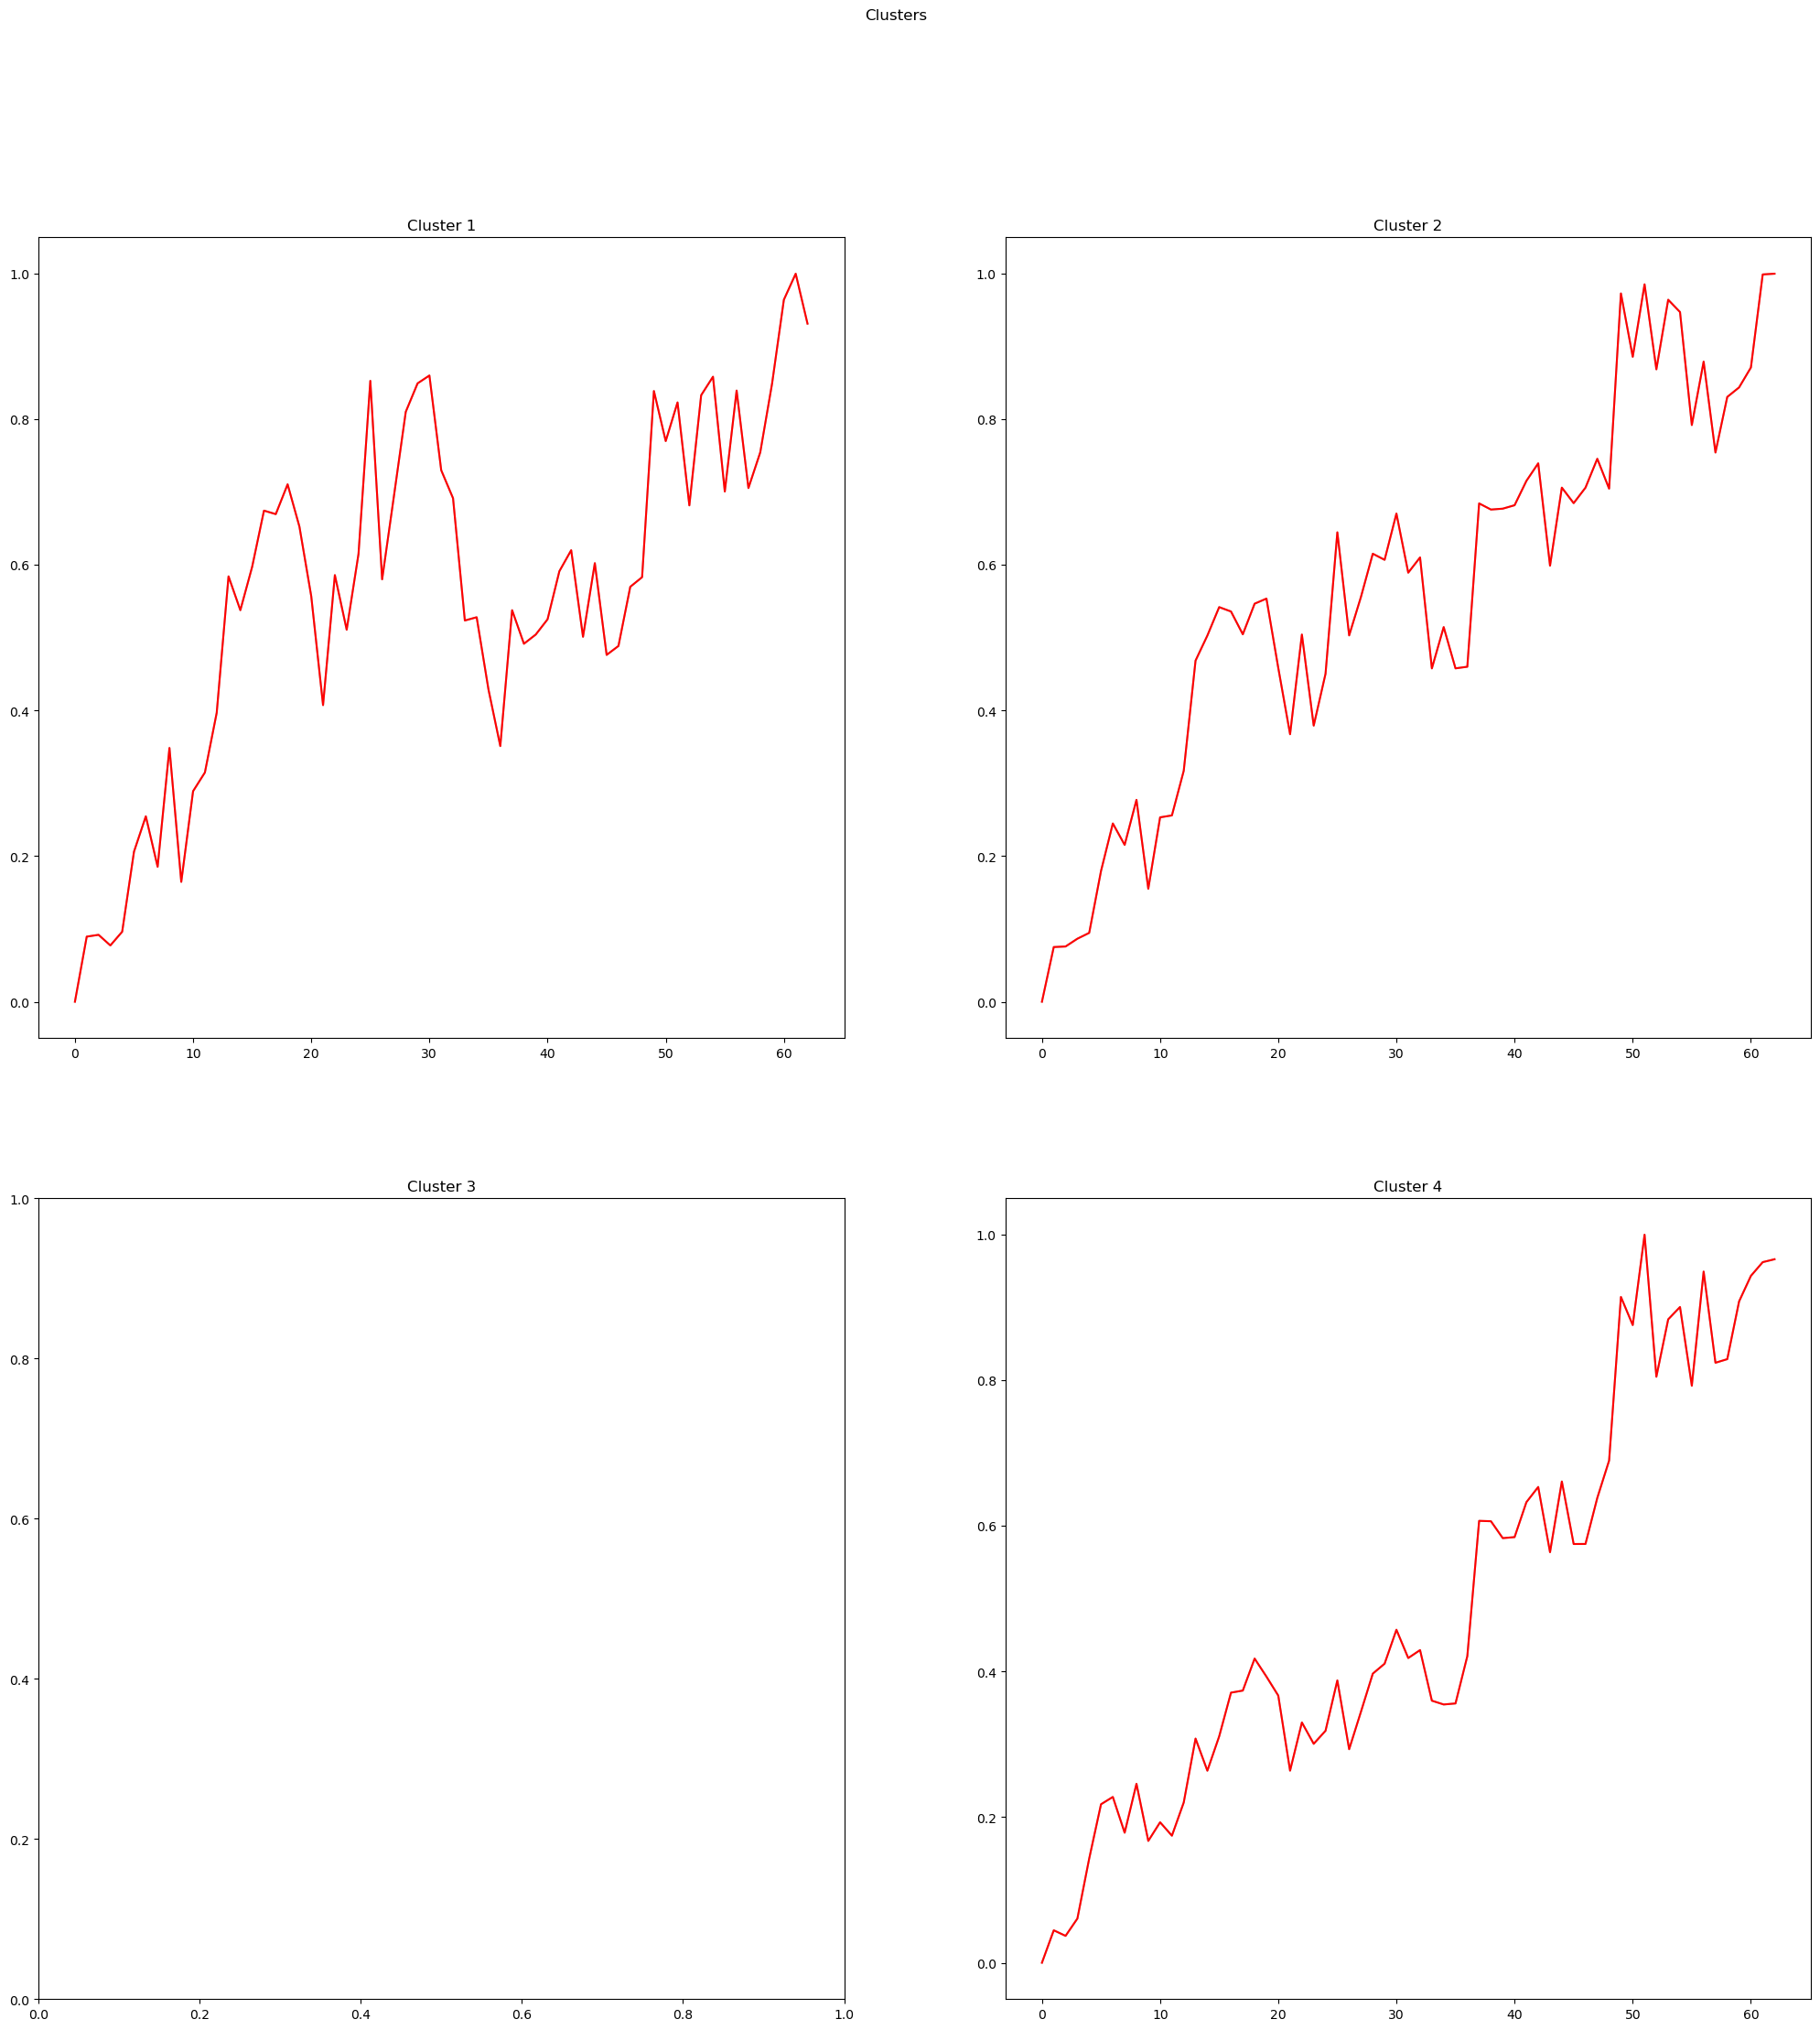

(0, 1)
(0, 0)
(1, 1)


Cluster
Series           
CA_2    Cluster 1
CA_1    Cluster 2
CA_3    Cluster 4

In [46]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
som = MiniSom(som_x, som_y,len(mySeries[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(mySeries)
som.train(mySeries, 50000)

def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

win_map = som.win_map(mySeries)

plot_som_series_averaged_center(som_x, som_y, win_map)

for series in mySeries[:5]:
    print(som.winner(series))

cluster_map = []
for idx in range(len(mySeries)):
    winner_node = som.winner(mySeries[idx])
    cluster_map.append((namesofMySeries[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

K Means clustering

In [50]:
cluster_count = math.ceil(math.sqrt(len(mySeries))) 

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(mySeries)

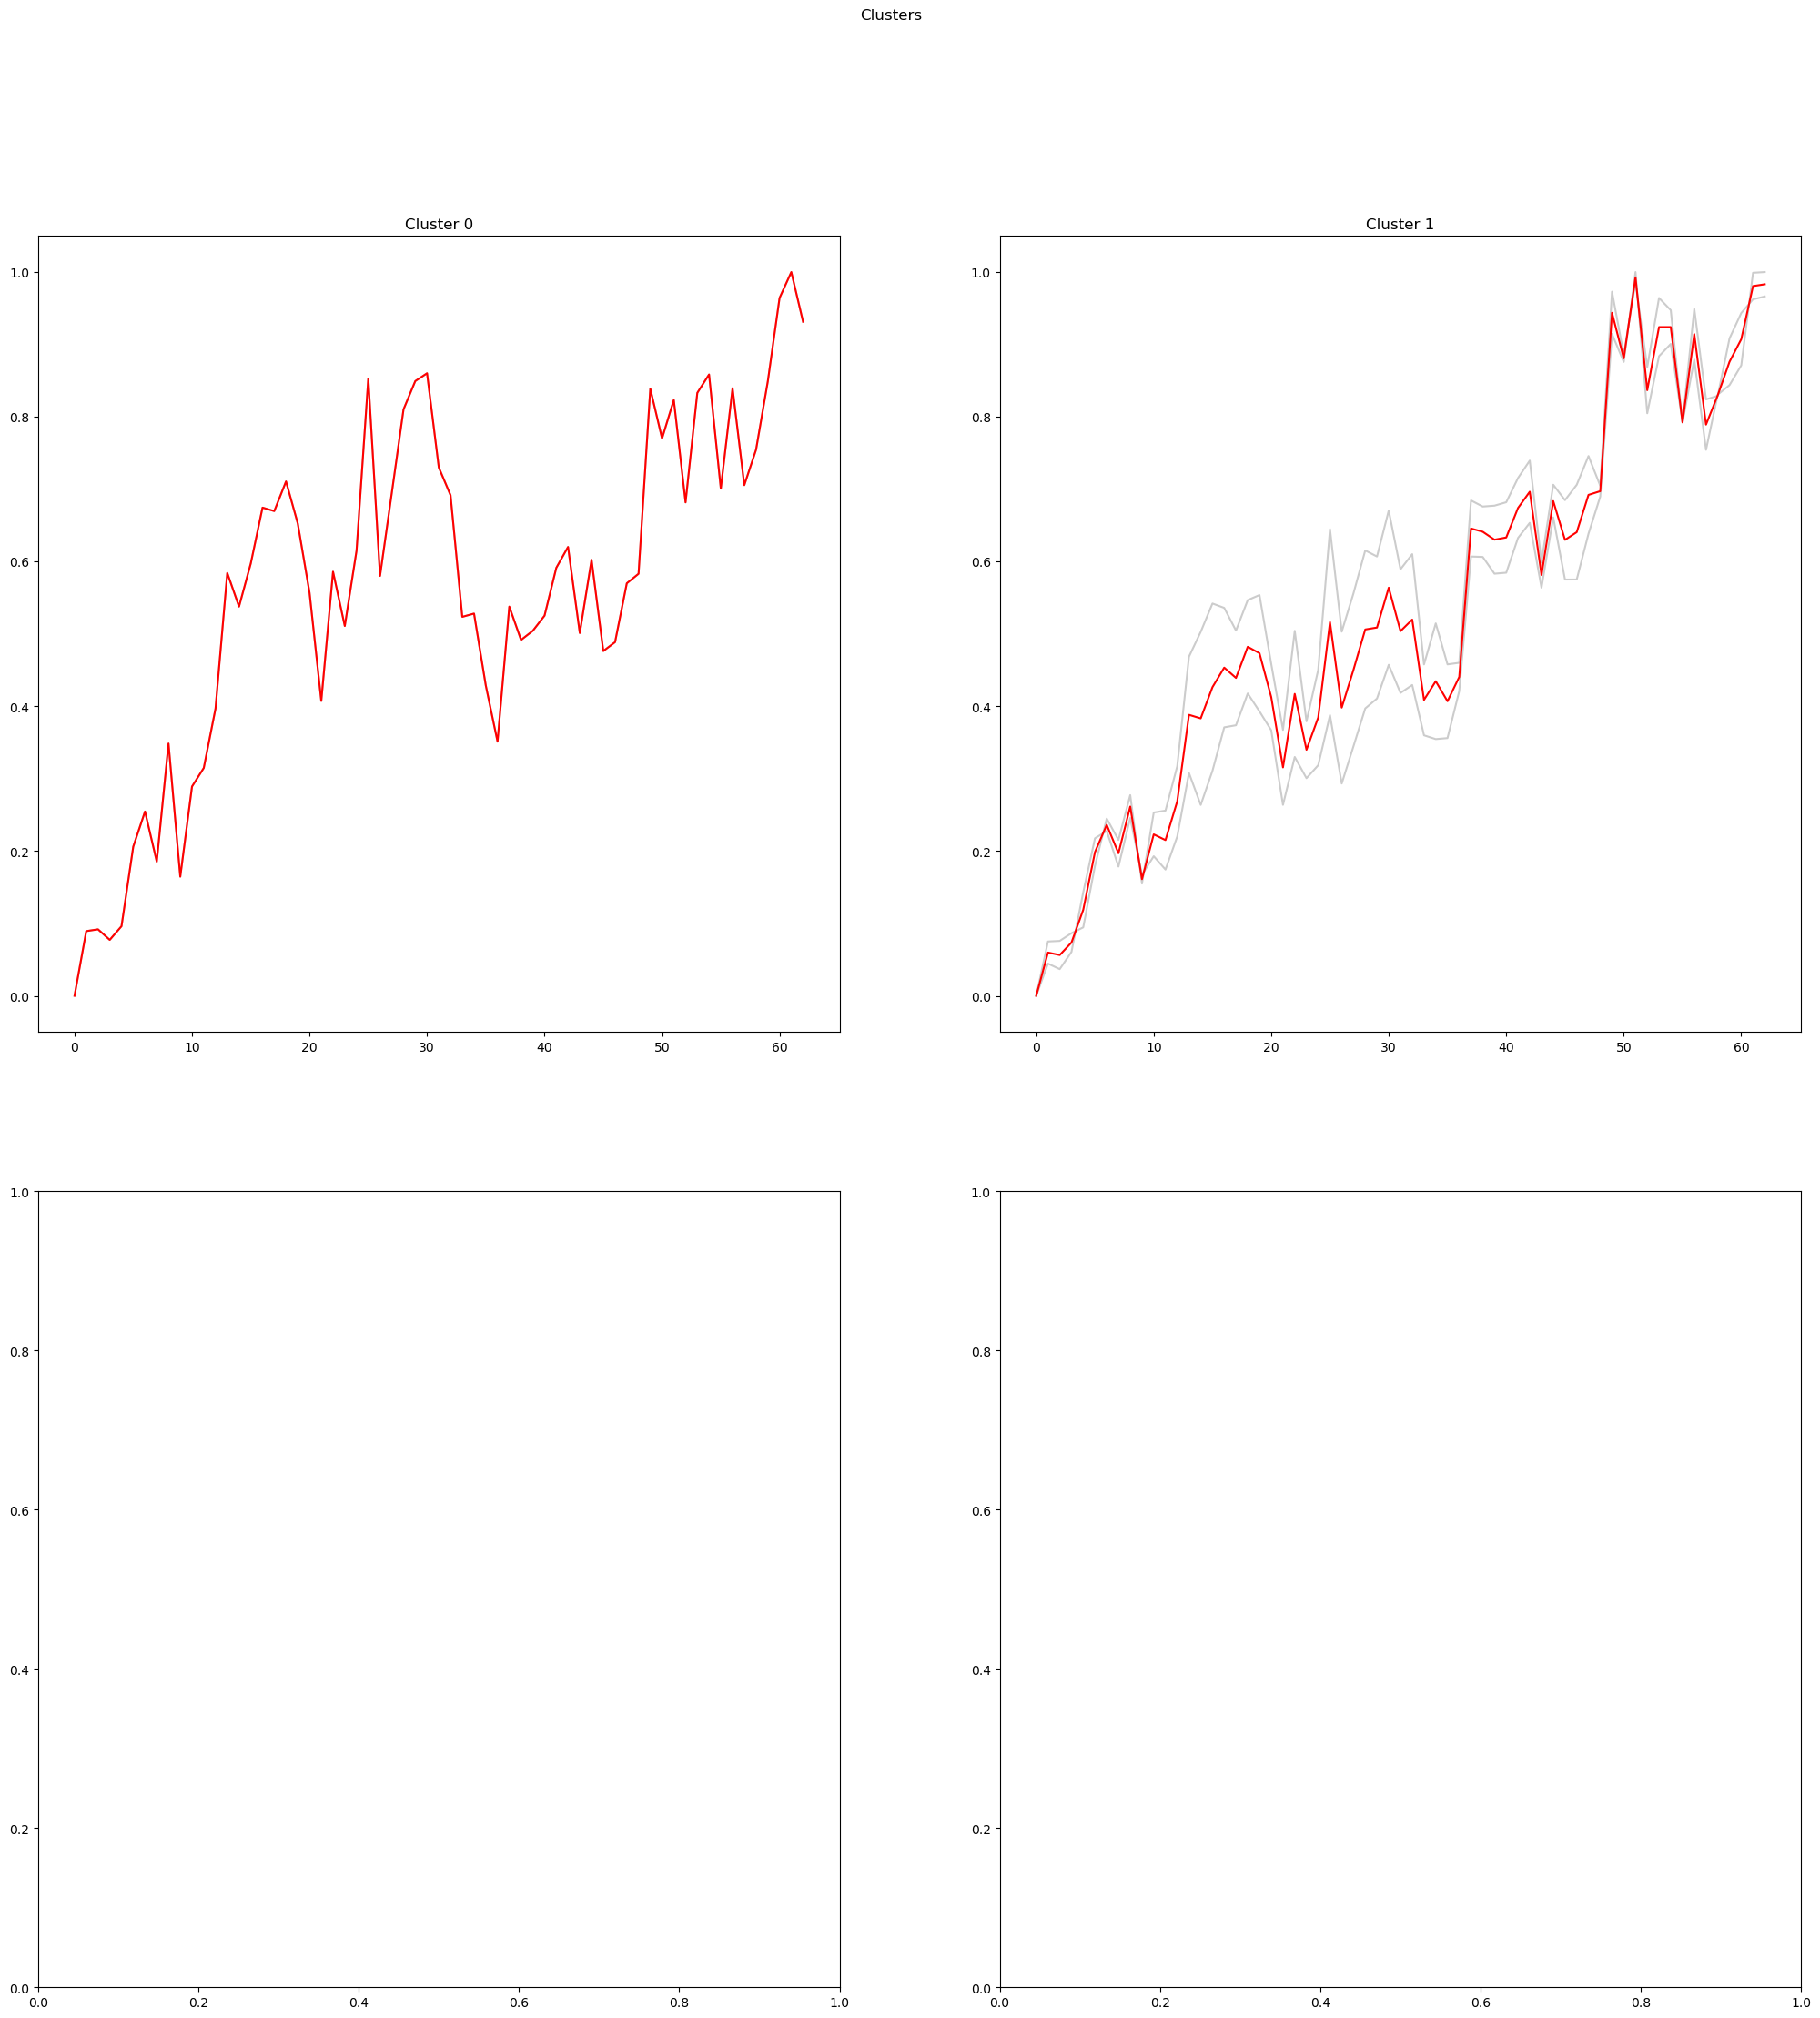

In [51]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0

for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

In [52]:
labels

array([1, 0, 1])

In [53]:
names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(namesofMySeries,names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

Cluster
Series           
CA_2    Cluster 0
CA_1    Cluster 1
CA_3    Cluster 1

In [36]:
CA_monthly_ind=[]
CA_monthly=pd.read_excel("files/CA__monthly.xlsx",parse_dates=True).set_index("date")
CA_monthly.index.freq="MS"
CA1=pd.read_excel("files/CA_1.xlsx",parse_dates=True).set_index("date")
CA2=pd.read_excel("files/CA_2.xlsx",parse_dates=True).set_index("date")
CA3=pd.read_excel("files/CA_3.xlsx",parse_dates=True).set_index("date")
CA_monthly_long=pd.read_excel("files/CA__monthly_long.xlsx",parse_dates=True).set_index("date")
for i in [CA1,CA2,CA3]:
    CA_monthly_ind.append(i["Total_sales"])

In [37]:
Train=CA_monthly[:-9]
Test=CA_monthly[-9:]
Train_ind=[i[:-9] for i in CA_monthly_ind]
Test_ind=[i[-9:] for i in CA_monthly_ind]
Train_long=CA_monthly_long.loc["02-2011":"07-2015"]
Test_long=CA_monthly_long.loc["08-2015":]

### Exploratory Data Analysis

#### Rolling Mean and Sales 

IndexError: list index out of range

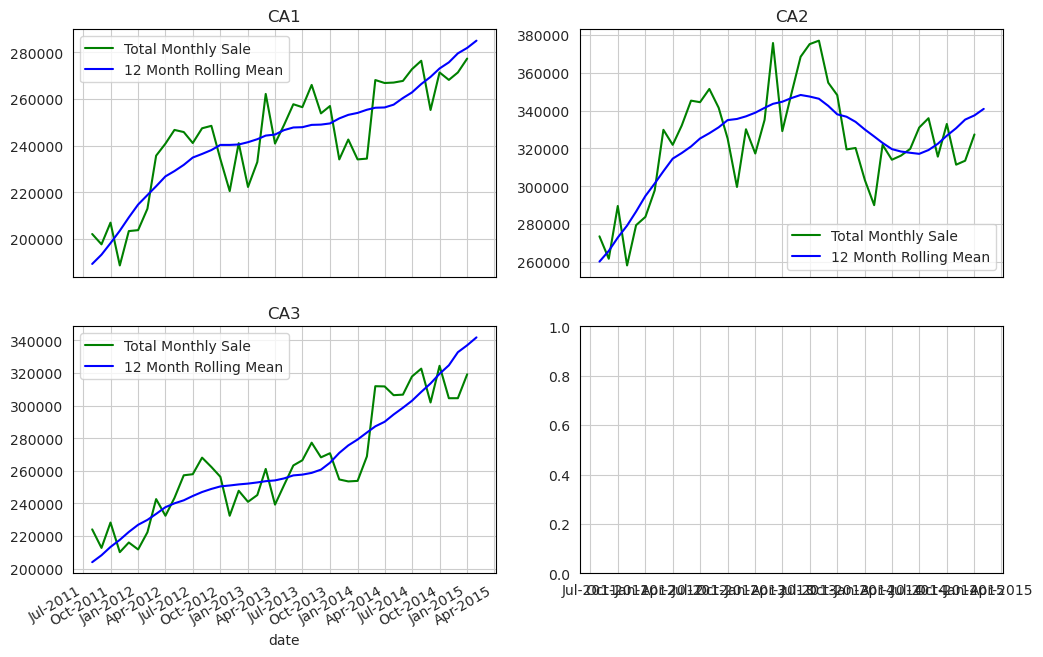

In [38]:
sns.set_style("whitegrid",{"axes.edgecolor": "black"})
fig, axes = plt.subplots(figsize=(12,8),nrows=2, ncols=2,sharex=True)
k=0;
for i in range(2):
    for y in range(2):
        Train_ind[k][6:-6].plot(legend=True,label="Total Monthly Sale",color="green",ax=axes[i][y],grid=True,x_compat=True,title="CA"+str(k+1))
        Train_ind[k].rolling(12,center=True).mean().plot(legend=True,color="blue",label="12 Month Rolling Mean",ax=axes[i][y],grid=True,x_compat=True)
        axes[i][y].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        axes[i][y].xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
        k=k+1
fig.suptitle("Monthly Sale And Rolling Mean")

In [ ]:
fig, ax = plt.subplots(figsize = (15,10),nrows=2,ncols=2)
for i in range(4):
    sns.boxplot(x=Train_ind[i].index.year.tolist(),y=Train_ind[i] ,ax=ax[int(i/2)][i%2], boxprops=dict(alpha=.3));
    sns.swarmplot(y=Train_ind[i],ax=ax[int(i/2)][i%2] ,x=Train_ind[i].index.year.tolist())
    ax[int(i/2)][i%2].set_title("CA"+str(i+1))
    ax[int(i/2)][i%2].grid(True)
    ax[int(i/2)][i%2].set_xlabel("Year")
fig.suptitle("Box-Plot")
fig.tight_layout()

#### Monthly trends & distrbution

**Monthly Subseries Plot**

In [ ]:
Train_ss=Train_long.copy()
Train_ss["Year"]=Train_ss.index.year.tolist()
Train_ss["Month"]=Train_ss.index.month.tolist()
fg_grid=sns.relplot(data=Train_ss.reset_index(),
                x="Year",
                hue="store_id",
                y="Total_sales",
                col="Month",
                kind="line",
                col_wrap=4,
                height=3.2,
                aspect=1.06,
                facet_kws={"sharex":False,"xlim":(2010.5,2015.5),"sharey":True}
).figure.suptitle("Monthly Sales Over the Years For Different Stores")
fg_grid.figure.tight_layout()

**Distribution Plot**

In [ ]:
fg_grid=sns.displot(data=Train_ss.reset_index(),
            x="Total_sales",
            kind="kde",
            col="store_id",
            col_wrap=2,
            palette="rainbow",
            hue="Year",
            legend=True,
            facet_kws={"sharex":False},
            height=3.3,
            aspect=1.8,
            common_norm=False).figure.suptitle("Density Plots for Different Years") 
fg_grid.figure.tight_layout()

**Heat-Map**

In [ ]:
fig, axes = plt.subplots(figsize=(12,8),nrows=2, ncols=2,sharey=True)
p=pd.pivot_table(data=Train_ss[["store_id","Total_sales","Month","Year"]], 
                 index=["store_id","Year"],
                 columns="Month",
                 values="Total_sales")
k=0;
for i in range(2):
    for y in range(2):
        k=k+1
        t=sns.heatmap(p.loc["TX_"+str(k)],
                    square=True,
                    cmap='Blues',
                    ax=axes[i][y],
                    cbar=True,
                    cbar_kws={"orientation":"horizontal"});
        axes[i][y].set_title("CA"+str(k))
        axes[i][y].tick_params('y', labelrotation=0) 
        if y==1: axes[i][y].set_ylabel(None) 
fig.suptitle("Heat-Map")
fig.tight_layout()

**Stacked Bar Graph-Each Month Share in Total Sales**

In [ ]:
fig,ax=plt.subplots(figsize=(12,10),nrows=2,ncols=2,sharey=True)
for j in range(4): 
        sum_of_years=p.loc["TX_"+str(j+1)].loc[2012:2014].sum(axis=1)
        p_percentage=p.loc["TX_"+str(j+1)].loc[2012:2014].divide(sum_of_years,axis=0)*100
        p_percentage.plot(kind='barh', stacked=True, title="TX_"+str(j+1),ax=ax[int(j/2)][j%2],legend=False,colormap="Paired")
handles, labels = ax[0][0].get_legend_handles_labels()
fig.suptitle("Percentage of Sales in Individual Months for Different Years")
fig.legend(handles, labels,bbox_to_anchor=(0.97,0.6),title="Month")
plt.show()

### Decomposition

1. **TX1**

In [ ]:
decompose_CA1 = seasonal_decompose(Train["TX_1"])
decompose_CA1.plot().set(figheight=8.1,figwidth=10.8)

In [ ]:
ljung_p=np.mean(ljung(decompose_CA1.resid.dropna(),lags=24,return_df=True)["lb_pvalue"])
print("p-value :",ljung_p, "\nSince p < 0.05 =",str(ljung_p<0.05)+","
                     ,"The residuals are uncorelated" if ljung_p<0.05 else "The resisuals are co-related")

2. **TX2**

In [ ]:
decompose_CA2 = seasonal_decompose(Train["TX_2"])
decompose_CA2.plot().set(figheight=8.1,figwidth=10.8)

In [ ]:
ljung_p=np.mean(ljung(decompose_CA2.resid.dropna(),lags=24,return_df=True)["lb_pvalue"])
print("p-value :",ljung_p, "\nSince p < 0.05 =",str(ljung_p<0.05)+","
                     ,"The residuals are uncorelated" if ljung_p<0.05 else "The resisuals are co-related")

3. **TX3**

In [ ]:
decompose_CA3 = seasonal_decompose(Train["TX_3"])
decompose_CA3.plot().set(figheight=8.1,figwidth=10.8)

In [ ]:
ljung_p=np.mean(ljung(decompose_CA3.resid.dropna(),lags=24,return_df=True)["lb_pvalue"])
print("p-value :",ljung_p, "\nSince p < 0.05 =",str(ljung_p<0.05)+","
                     ,"The residuals are uncorelated" if ljung_p<0.05 else "The resisuals are co-related")

### Stationarity


1. **TX1**

In [ ]:
fig,ax1=plt.subplots(figsize=(12,4),nrows=1,ncols=2)
Train["TX_1"].plot(ax=ax1[0],legend=True,label="Train",cmap="gray",title="Actual Sales and Mean")
Train["TX_1"].rolling(12,center=False).mean().plot(legend=True,ax=ax1[0],label="12 Month Rolling Mean")
Train["TX_1"].rolling(12,center=False).std().plot(ax=ax1[1],title="Standard Deviation",ylim=(14000,42000),label="12 Month Rolling Standard Deviation",legend=True)
fig.tight_layout()
print("Standard Deviation:",Train["TX_1"].std())

In [ ]:
print("Coefficient of Variation:",Train["TX_1"].std()/Train["TX_1"].mean())

In [ ]:
fig,ax1=plt.subplots(figsize=(13,4),nrows=1,ncols=2)
plot_acf(Train["TX_1"],ax=ax1[0]);
plot_pacf(Train["TX_1"],ax=ax1[1]);

In [ ]:
adf = adfuller(Train["TX_1"])[1]
print(f"p value:{adf.round(4)}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

In [39]:
adf2 = adfuller(Train["TX_1"].diff(1).dropna())[1]
print(f"p value:{adf2.round(4)}", ", Series is Stationary" if adf2 <0.05 else ", Series is Non-Stationary")
adf2 = adfuller(Train["TX_1"].diff(1).diff(1).dropna())[1]
print(f"p value:{adf2.round(4)}", ", Series is Stationary" if adf2 <0.05 else ", Series is Non-Stationary")

p value:0.4014 , Series is Non-Stationary

p value:0.0 , Series is Stationary


2. **TX2**

Standard Deviation: 38420.59855949567


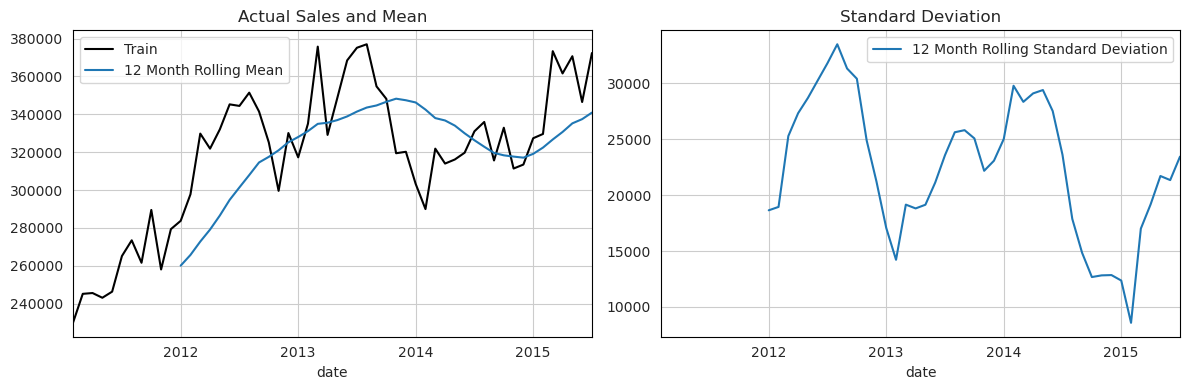

In [40]:
fig,ax1=plt.subplots(figsize=(12,4),nrows=1,ncols=2)
Train["TX_2"].plot(ax=ax1[0],legend=True,label="Train",cmap="gray",title="Actual Sales and Mean")
Train["TX_2"].rolling(12,center=False).mean().plot(legend=True,ax=ax1[0],label="12 Month Rolling Mean")
Train["TX_2"].rolling(12,center=False).std().plot(ax=ax1[1],title="Standard Deviation",label="12 Month Rolling Standard Deviation",legend=True)
fig.tight_layout()
print("Standard Deviation:",Train["TX_2"].std())

In [41]:
print("Coefficient of Variation:",Train["TX_2"].std()/Train["TX_1"].mean())

Coefficient of Variation: 0.15844963967380293


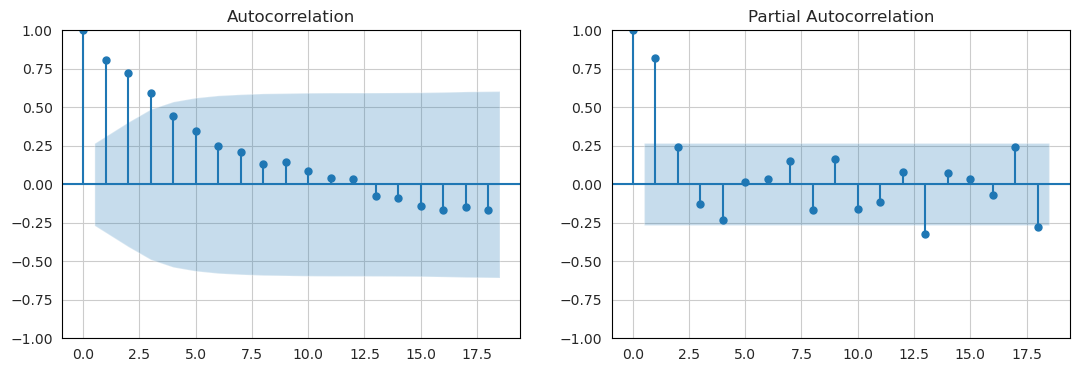

In [42]:
fig,ax1=plt.subplots(figsize=(13,4),nrows=1,ncols=2)
plot_acf(Train["TX_2"],ax=ax1[0]);
plot_pacf(Train["TX_2"],ax=ax1[1]);

In [43]:
adf = adfuller(Train["TX_2"])[1]
print(f"p value:{adf.round(4)}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.1477 , Series is Non-Stationary


2. **TX3**

Standard Deviation: 53442.06849344413


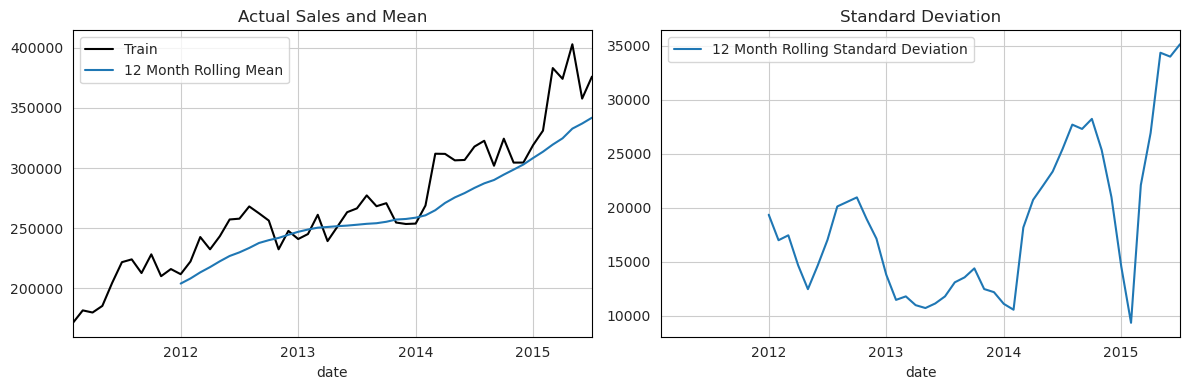

In [44]:
fig,ax1=plt.subplots(figsize=(12,4),nrows=1,ncols=2)
Train["TX_3"].plot(ax=ax1[0],legend=True,label="Train",cmap="gray",title="Actual Sales and Mean")
Train["TX_3"].rolling(12,center=False).mean().plot(legend=True,ax=ax1[0],label="12 Month Rolling Mean")
Train["TX_3"].rolling(12,center=False).std().plot(ax=ax1[1],title="Standard Deviation",label="12 Month Rolling Standard Deviation",legend=True)
fig.tight_layout()
print("Standard Deviation:",Train["TX_3"].std())

In [45]:
print("Coefficient of Variation:",Train["TX_3"].std()/Train["TX_3"].mean())

Coefficient of Variation: 0.1998404799495629


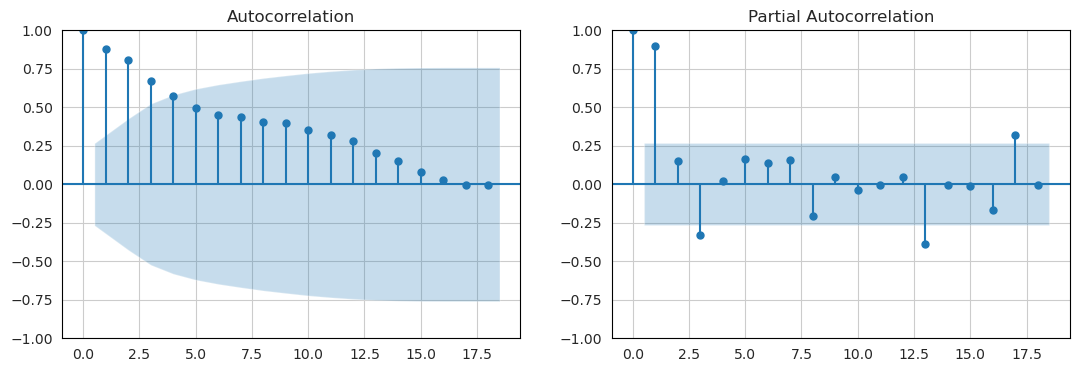

In [46]:
fig,ax1=plt.subplots(figsize=(13,4),nrows=1,ncols=2)
plot_acf(Train["TX_3"],ax=ax1[0]);
plot_pacf(Train["TX_3"],ax=ax1[1]);

In [47]:
adf = adfuller(Train["TX_3"])[1]
print(f"p value:{adf.round(4)}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")


p value:0.9963 , Series is Non-Stationary


**Distribution Plot**

In [48]:
fg_obj=sns.displot(data=Train_ss[["store_id","Total_sales"]].reset_index(),
            x="Total_sales",
            kind="hist",
            col="store_id",
            col_wrap=2,
            facet_kws={"sharex":True,"sharey":False},
            kde=True,
            stat="density",
            legend=True,
            height=3.3,
            aspect=1.8).tight_layout()

NameError: name 'Train_ss' is not defined

In [49]:
is_norm=pd.DataFrame(columns=["store_id","jb_p_value","Distribution"])
for i in ["TX_1","TX_2","TX_3"]:
    p_value=jb(Train[i])[1]
    is_norm=pd.concat([is_norm,
               pd.DataFrame([{"store_id":i,
                              "jb_p_value":p_value,
                              "Distribution":"Normal" if p_value>0.05 else "Not Normal"}]
                           )],
               ignore_index=True)
is_norm

store_id  jb_p_value Distribution
0     TX_1    0.637645       Normal
1     TX_2    0.219679       Normal
2     TX_3    0.253922       Normal

## Model Fitting and Selection

In [50]:
def MAPE(y_true,y_pred):
    ytrue,ypred=np.array(y_true),np.array(y_pred)
    accuracy_df=pd.DataFrame()
    MAPE1=np.round(np.mean(np.abs(ytrue-ypred)/ytrue)*100,1)
    return MAPE1

def accuracy(y_true,y_pred):
    ytrue,ypred=np.array(y_true),np.array(y_pred)
    MAPE1=MAPE(y_true,y_pred)
    rmse_r=np.round(rmse(ytrue,ypred),1)
    return pd.DataFrame({"RMSE":[rmse_r],"MAPE":[MAPE1]})

def residualcheck(residuals, lags):
    
    resid_mean=np.mean(residuals)
    ljp_valve=np.mean(ljung(x=residuals,lags=lags,return_df=False)[1])
    adfuller1=adfuller(residuals)[1]
    isnorm=jb(residuals)[1]
    
    fig = plt.figure(figsize=(8,6))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout,(0,0),colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));
    
    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals,ax=kde_ax);
    sns.despine()
    plt.tight_layout();
    
    print("** Mean of the residuals: ", np.around(resid_mean,2))
    
    print("\n** Ljung Box Test, p-value:", ljp_valve, "(>0.05, Uncorrelated)" if (ljp_valve > 0.05) else "(<0.05, Correlated)")
    
    print("\n** Jarque Bera Normality Test, p_value:", np.around(isnorm,3), "(>0.05, Normal)" if (isnorm>0.05) else "(<0.05, Not-normal)")
    
    print("\n** AD Fuller, p_value:", adfuller1, "(>0.05, Non-stationary)" if (adfuller1 > 0.05) else "(<0.05, Stationary)")
    

    return ts_ax, acf_ax, kde_ax

### Seasonal Naive Forecast

In [51]:
Model_Performance=pd.DataFrame(columns=["store_id","Forecast Method","MAPE","RMSE"])
store_list=["TX_1","TX_2","TX_3"]

In [52]:
def snaive(train,seasons,forecast_horizon):
    if len(train)>forecast_horizon:
        last_season=train[-seasons:]
        reps=int(np.ceil(forecast_horizon/seasons))
        fc= np.tile(last_season,reps)
        forecast=fc[:forecast_horizon]
        fitted=train.shift(seasons)
        return forecast,fitted
    else:
        return "error"

In [53]:
predicted_naive=pd.DataFrame(columns=store_list)
fit_naive=pd.DataFrame(columns=store_list)
for i in store_list:
    forecast,fit=snaive(Train[i],12,9)
    predicted_naive[i]=forecast
    fit_naive[i]=fit
predicted_naive.set_index(Test.index,inplace=True)
fit_naive.set_index(Train.index,inplace=True)

KeyError: 'TX_4'

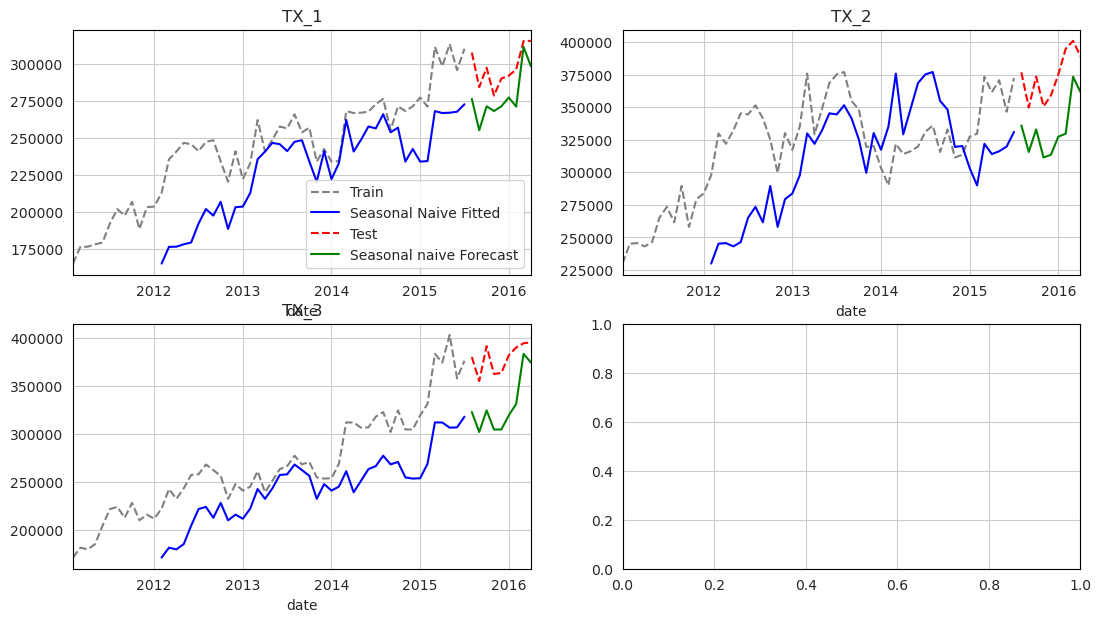

In [54]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["TX_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_naive["TX_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="Seasonal Naive Fitted",ax=axs).set_title(store_list[i])
    Test["TX_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs).set_title(store_list[i])
    predicted_naive["TX_"+str(i+1)].plot(color="g",legend=(i==0) ,label="Seasonal naive Forecast",ax=axs).set_title(store_list[i]);
fig.tight_layout()


In [ ]:
for i in store_list:
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":"Seasonal Naive",
                  "MAPE":accuracy(Test[i],predicted_naive[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_naive[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [ ]:
Model_Performance

In [ ]:
residual_naive=[(Train[i]-fit_naive[i]).dropna() for i in store_list]

In [ ]:
for i in range(len(store_list)):
    print("\n Store Name TX_"+str(i+1))
    residualcheck(residual_naive[i],24);
    plt.show()

### HoltsWinter Exponential Smoothing Model

In [95]:
def HoltsWinterGrid(train,test,seasonal_periods):
    trend=["add","mul"]
    seasonal=["add","mul"]
    damped=[False,True]
    use_boxcox=[True,False,"log"]
    
    params=itertools.product(trend,seasonal,damped,use_boxcox)
    result_df=pd.DataFrame(columns=["Trend","Seasonal","Damped","Box_Cox","AICc_Train","MAPE_Train",
                                   "RMSE_Train","MAPE_Test","RMSE_Test","lj_residual","jb_norm_residual",
                                   "resid_mean"])
    
    for trend,seasonal,damped,boxcox in params:
        if boxcox!="log":
            model=ExponentialSmoothing(train,
                                       trend=trend,
                                       seasonal=seasonal,
                                       damped_trend=damped,
                                       seasonal_periods=seasonal_periods,
                                       use_boxcox=boxcox,
                                       initialization_method="heuristic",
                                       freq='MS').fit()

            MAPE_Train=MAPE(train,model.fittedvalues)
            rmse_train=rmse(train,model.fittedvalues)

            MAPE_Test=MAPE(test,model.forecast(len(test)))
            rmse_test=rmse(test,model.forecast(len(test)))
            resid=model.resid
            
        else:
            trainlog=np.log(train)
            model=ExponentialSmoothing(trainlog,
                                   trend=trend,
                                   seasonal=seasonal,
                                   damped_trend=damped,
                                   seasonal_periods=seasonal_periods,
                                   use_boxcox=False,
                                   initialization_method="heuristic",
                                   freq='MS').fit()
        
            MAPE_Train=MAPE(train,np.exp(model.fittedvalues))
            rmse_train=rmse(train,np.exp(model.fittedvalues))
        
            MAPE_Test=MAPE(test,np.exp(model.forecast(len(test))))
            rmse_test=rmse(test,np.exp(model.forecast(len(test))))
            resid=train-np.exp(model.fittedvalues)
        
        
        ljp_p_val=np.mean(ljung(resid,lags=20,return_df=False)[1])
        norm_p=jb(resid)[1]
        lj_residual="Uncorrelated" if ljp_p_val>0.05 else "Corelated"
        norm_p="Normal" if norm_p>0.05 else "Not Normal"
       
        Aicc=model.aicc.round(1)
        
        result_df = pd.concat([result_df,
                              pd.DataFrame({
                                  'Trend':[trend],
                                  'Seasonal': [seasonal],
                                  'Damped':[damped],
                                  'Box_Cox':[boxcox],
                                  'MAPE_Train':[np.round(MAPE_Train,2)],
                                  'RMSE_Train':[np.round(rmse_train,1)],
                                  'AICc_Train':[Aicc],
                                  'MAPE_Test':[np.round(MAPE_Test,2)],
                                  'RMSE_Test':[np.round(rmse_test,1)],
                                  'lj_residual' :[lj_residual],
                                  'jb_norm_residual':[norm_p],
                                  'resid_mean':[np.round(resid.mean(),1)]})] ,
                              ignore_index=True, 
                              sort=False)
            
    return result_df.sort_values(by=["RMSE_Test","MAPE_Test","RMSE_Train","MAPE_Train"])#.style.format({"MAPE_Train":"{:24,.2f}%","MAPE_Test":"{:24,.2f}%"}).highlight_min(subset=["AICc_Train","MAPE_Train","RMSE_Train","MAPE_Test","RMSE_Test"],color='lightgreen')

In [96]:
HW_model_all=pd.DataFrame()
HW_model_best=pd.DataFrame()
for i,j in enumerate(store_list):
    temp2=HoltsWinterGrid(Train[j], Test[j], seasonal_periods=12)
    temp2["store_id"]=j
    HW_model_all=pd.concat([HW_model_all,temp2],ignore_index=True)
    HW_model_best=pd.concat([HW_model_best,temp2.head(1)],ignore_index=True)

In [98]:
HW_model_all[HW_model_all["store_id"]=="TX_2"]

Trend Seasonal Damped Box_Cox  AICc_Train  MAPE_Train  RMSE_Train  \
24   mul      add  False    True      1089.5         3.7     14922.4   
25   mul      add  False     log      -312.9         2.7     11154.3   
26   add      add  False     log      -313.0         2.7     11141.7   
27   mul      add   True    True      1093.5         3.7     14818.8   
28   mul      add   True   False      1076.7         3.2     12683.5   
29   add      add  False    True      1086.2         3.6     14481.2   
30   add      add   True    True      1090.2         3.6     14361.2   
31   mul      add  False   False      1071.8         3.2     12667.0   
32   add      add  False   False      1070.6         3.1     12522.6   
33   mul      mul  False    True      1069.3         3.0     12381.7   
34   mul      mul  False   False      1068.3         3.0     12260.0   
35   mul      mul   True    True      1073.3         3.0     12285.1   
36   mul      mul   True   False      1072.1         3.0     12149.6   
37   add      add   True   False      1074.6         3.1     12434.0   
38   add      mul  False   False      1066.9         3.0     12106.1   
39   add      add   True     log      -312.0         2.6     10623.4   
40   add      mul   True   False      1070.9         3.0     12011.8   
41   add      mul  False    True      1066.5         2.9     12060.5   
42   mul      add   True     log      -213.8         7.8     27412.0   
43   add      mul  False     log         NaN         NaN         NaN   
44   add      mul   True    True         NaN         NaN         NaN   
45   add      mul   True     log         NaN         NaN         NaN   
46   mul      mul  False     log         NaN         NaN         NaN   
47   mul      mul   True     log         NaN         NaN         NaN   

    MAPE_Test  RMSE_Test   lj_residual jb_norm_residual  resid_mean store_id  
24        4.4    20157.3  Uncorrelated           Normal     -2226.5     TX_2  
25        4.5    21204.6  Uncorrelated           Normal      -861.7     TX_2  
26        4.6    21403.6  Uncorrelated           Normal      -865.0     TX_2  
27        4.7    21431.6  Uncorrelated           Normal     -2149.3     TX_2  
28        4.7    21675.0  Uncorrelated           Normal     -3102.1     TX_2  
29        5.6    25253.0  Uncorrelated           Normal     -1656.1     TX_2  
30        5.7    25374.0  Uncorrelated           Normal     -2013.9     TX_2  
31        5.6    25467.2  Uncorrelated           Normal     -1891.5     TX_2  
32        5.9    26624.3  Uncorrelated           Normal     -1946.5     TX_2  
33        5.9    26728.3  Uncorrelated           Normal     -2457.7     TX_2  
34        6.0    27555.1  Uncorrelated           Normal     -1938.7     TX_2  
35        6.1    27816.3  Uncorrelated           Normal     -2528.1     TX_2  
36        6.2    28066.8  Uncorrelated           Normal     -2078.7     TX_2  
37        6.2    28075.9  Uncorrelated           Normal     -1441.8     TX_2  
38        6.3    28443.3  Uncorrelated           Normal     -2020.6     TX_2  
39        6.4    28802.4  Uncorrelated           Normal       -87.2     TX_2  
40        6.6    29838.9  Uncorrelated           Normal     -1515.1     TX_2  
41        6.7    30190.6  Uncorrelated           Normal     -2106.5     TX_2  
42       71.5   323486.1  Uncorrelated           Normal    -24802.2     TX_2  
43        NaN        NaN     Corelated       Not Normal         NaN     TX_2  
44        NaN        NaN     Corelated       Not Normal         NaN     TX_2  
45        NaN        NaN     Corelated       Not Normal         NaN     TX_2  
46        NaN        NaN     Corelated       Not Normal         NaN     TX_2  
47        NaN        NaN     Corelated       Not Normal         NaN     TX_2

In [99]:
HW_model_best=HW_model_best.set_index("store_id")
HW_model_best

Trend Seasonal Damped Box_Cox  AICc_Train  MAPE_Train  RMSE_Train  \
store_id                                                                     
TX_1       add      add   True     log      -328.5         2.3      6926.0   
TX_2       mul      add  False    True      1089.5         3.7     14922.4   
TX_3       add      add  False   False      1064.9         3.0     11884.3   

          MAPE_Test  RMSE_Test   lj_residual jb_norm_residual  resid_mean  
store_id                                                                   
TX_1            2.2     7544.2  Uncorrelated           Normal       214.4  
TX_2            4.4    20157.3  Uncorrelated           Normal     -2226.5  
TX_3            2.7    11795.2  Uncorrelated       Not Normal     -1198.8

In [100]:
predicted_HW=pd.DataFrame(columns=store_list)
fit_HW=pd.DataFrame(columns=store_list)
for i in store_list:
    if HW_model_best.loc[i].Box_Cox!="log":
            model=ExponentialSmoothing(Train[i],
                                       trend=HW_model_best.loc[i].Trend,
                                       seasonal=HW_model_best.loc[i].Seasonal,
                                       damped_trend=HW_model_best.loc[i].Damped,
                                       seasonal_periods=12,
                                       use_boxcox=HW_model_best.loc[i].Box_Cox,
                                       initialization_method="heuristic",
                                       freq='MS').fit()

            fit_HW[i]=model.fittedvalues
            predicted_HW[i]=model.forecast(len(Test))
            
    else:
            model=ExponentialSmoothing(np.log(Train[i]),
                                   trend=HW_model_best.loc[i].Trend,
                                   seasonal=HW_model_best.loc[i].Seasonal,
                                   damped_trend=HW_model_best.loc[i].Damped,
                                   seasonal_periods=12,
                                   use_boxcox=False,
                                   initialization_method="heuristic",
                                   freq='MS').fit()
            fit_HW[i]=np.exp(model.fittedvalues)
            predicted_HW[i]=np.exp(model.forecast(len(Test)))

KeyError: 'TX_4'

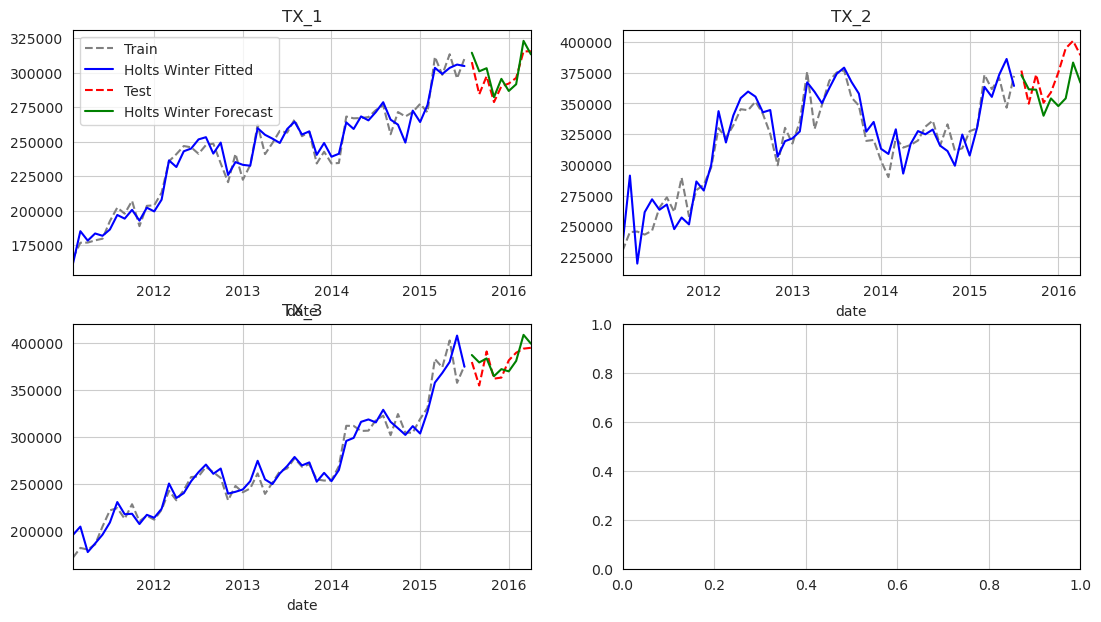

In [102]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["TX_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_HW["TX_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="Holts Winter Fitted",ax=axs)
    Test["TX_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_HW["TX_"+str(i+1)].plot(color="g",legend=(i==0) ,label="Holts Winter Forecast",ax=axs)
fig.tight_layout()



 Store Name TX_1

** Mean of the residuals:  214.4



** Ljung Box Test, p-value: 0.6110656140752239 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.981 (>0.05, Normal)



** AD Fuller, p_value: 1.4106070381568502e-11 (<0.05, Stationary)


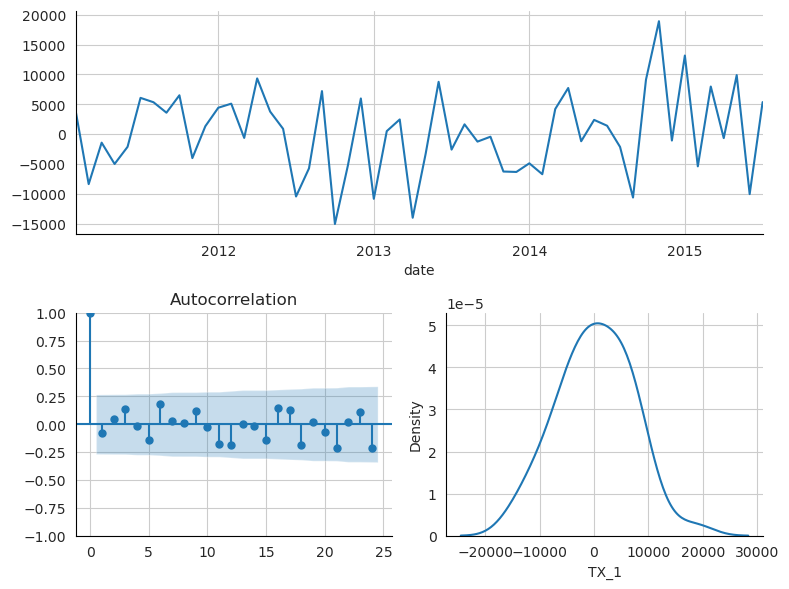



 Store Name TX_2

** Mean of the residuals:  -2226.53



** Ljung Box Test, p-value: 0.4141762897573771 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.168 (>0.05, Normal)



** AD Fuller, p_value: 1.979520631780773e-10 (<0.05, Stationary)


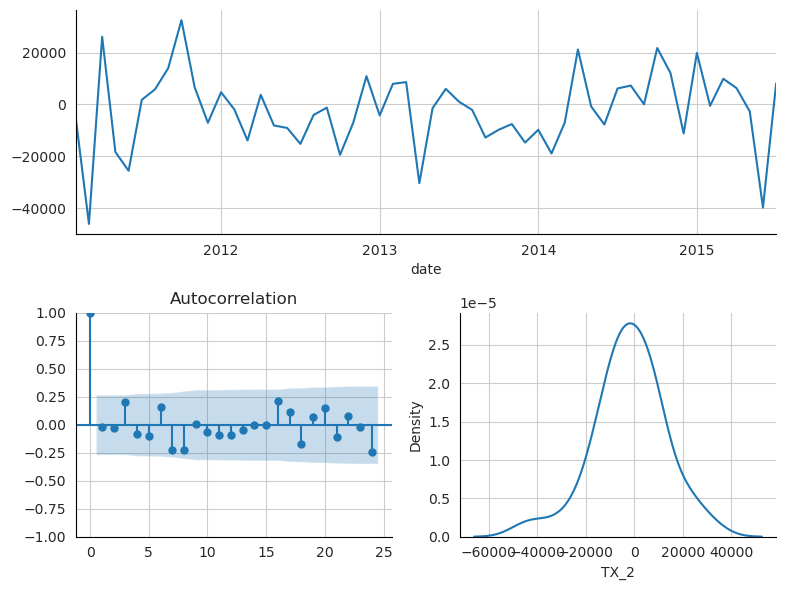



 Store Name TX_3

** Mean of the residuals:  -1198.81



** Ljung Box Test, p-value: 0.9033095080212495 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 7.927117874453874e-11 (<0.05, Stationary)


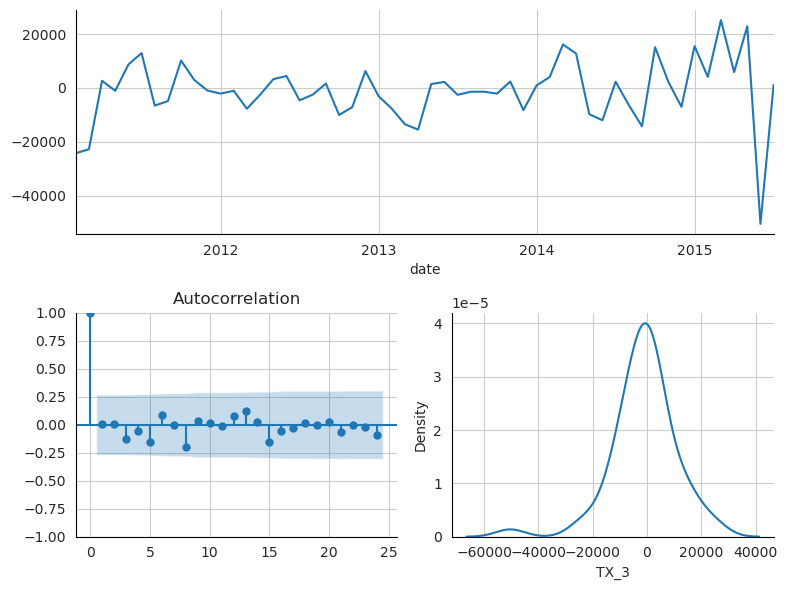

In [103]:
residual_HW=[(Train[i]-fit_HW[i]).dropna() for i in store_list]
for i in range(len(store_list)):
    print("\n Store Name TX_"+str(i+1))
    residualcheck(residual_HW[i],24);
    plt.show()

In [104]:
for i in store_list:
    if HW_model_best.loc[i].Box_Cox=="log":
        model_name="Holts-Winter Log"
    elif HW_model_best.loc[i].Box_Cox==True:
        model_name="Holts-Winter Box-Cox"
    else:
        model_name="Holts-Winter"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_HW[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_HW[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [105]:
Model_Performance

Forecast Method  MAPE     RMSE store_id
0               SARIMA Log   4.9  15740.5      NaN
1         Prophet Additive   5.9  17859.8      NaN
2   Prophet Multiplicative   5.8  18238.7      NaN
3               SARIMA Log   3.7  17449.6      NaN
4         Prophet Additive  10.1  41176.7      NaN
5   Prophet Multiplicative  10.9  44072.4      NaN
6         Prophet Additive   3.7  16779.6      NaN
7   Prophet Multiplicative   4.3  18659.8      NaN
8               SARIMA Log   3.7  25468.9      NaN
9         Holts-Winter Log   2.2   7544.2     TX_1
10    Holts-Winter Box-Cox   4.4  20157.3     TX_2
11            Holts-Winter   2.7  11795.2     TX_3

### ETS Model Statespace Aproach Log


In [106]:
predicted_ETSL=pd.DataFrame(columns=store_list)
fit_ETSL=pd.DataFrame(columns=store_list)
resid_ETSL=pd.DataFrame(columns=store_list)
ETSL_models=[]
for i in store_list:
    ets_LAdA=sm.tsa.statespace.ExponentialSmoothing(np.log(Train[i]),
                                               trend=True, 
                                               initialization_method= 'heuristic', 
                                               seasonal=12, 
                                               damped_trend=False).fit(disp=0)

    predicted_ETSL[i] = np.exp(ets_LAdA.forecast(len(Test[i])))
    fit_ETSL[i]=np.exp(ets_LAdA.fittedvalues)
    resid_ETSL[i]=Train[i]-fit_ETSL[i]
    ETSL_models.append(ets_LAdA)

KeyError: 'TX_4'

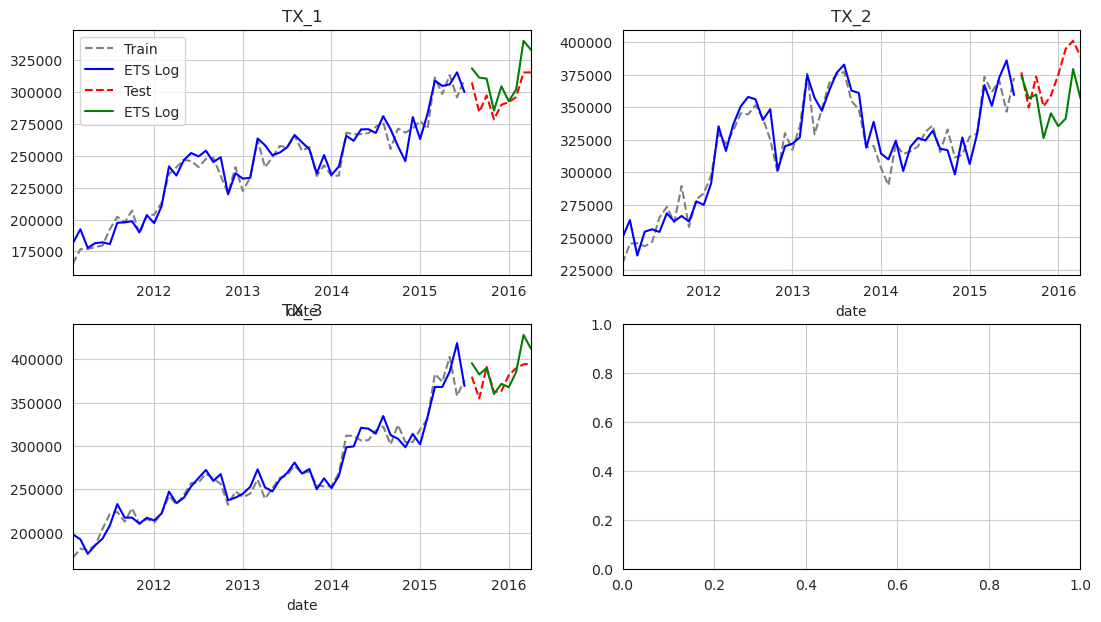

In [107]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["TX_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_ETSL["TX_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="ETS Log",ax=axs)
    Test["TX_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_ETSL["TX_"+str(i+1)].plot(color="g",legend=(i==0) ,label="ETS Log",ax=axs)
fig.tight_layout()

In [108]:
for i in store_list:
    model_name="ETS Log"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_ETSL[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_ETSL[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [109]:
Model_Performance

Forecast Method  MAPE     RMSE store_id
0               SARIMA Log   4.9  15740.5      NaN
1         Prophet Additive   5.9  17859.8      NaN
2   Prophet Multiplicative   5.8  18238.7      NaN
3               SARIMA Log   3.7  17449.6      NaN
4         Prophet Additive  10.1  41176.7      NaN
5   Prophet Multiplicative  10.9  44072.4      NaN
6         Prophet Additive   3.7  16779.6      NaN
7   Prophet Multiplicative   4.3  18659.8      NaN
8               SARIMA Log   3.7  25468.9      NaN
9         Holts-Winter Log   2.2   7544.2     TX_1
10    Holts-Winter Box-Cox   4.4  20157.3     TX_2
11            Holts-Winter   2.7  11795.2     TX_3
12                 ETS Log   4.5  15822.3     TX_1
13                 ETS Log   6.1  27842.3     TX_2
14                 ETS Log   3.7  17484.1     TX_3



 Store Name TX_1

** Mean of the residuals:  -1040.12



** Ljung Box Test, p-value: 0.37502691539554456 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.838 (>0.05, Normal)



** AD Fuller, p_value: 3.144031088399011e-15 (<0.05, Stationary)


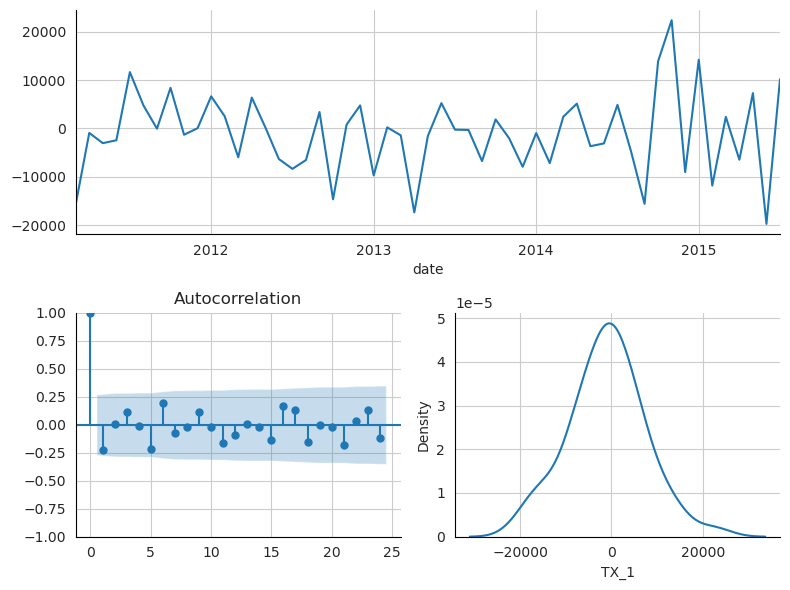



 Store Name TX_2

** Mean of the residuals:  -1505.06



** Ljung Box Test, p-value: 0.1489383923514341 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.09 (>0.05, Normal)



** AD Fuller, p_value: 1.2065745485536401e-11 (<0.05, Stationary)


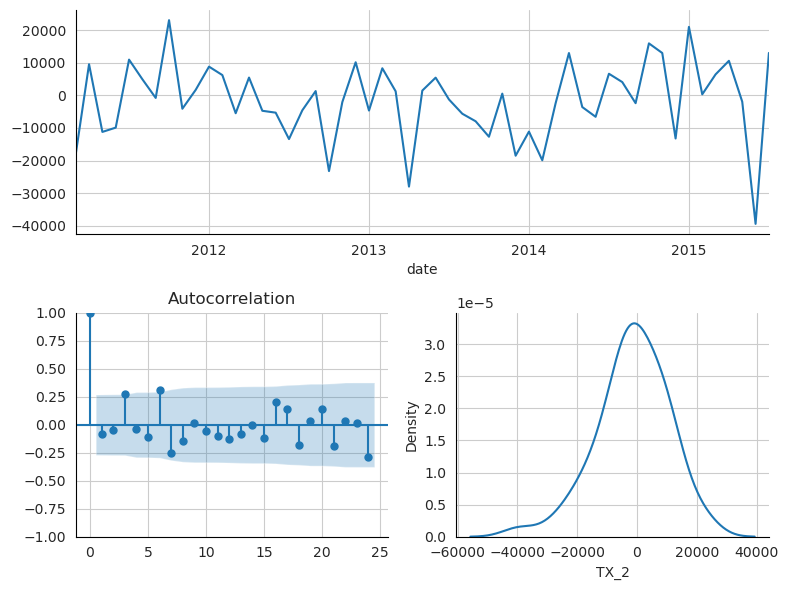



 Store Name TX_3

** Mean of the residuals:  -1033.26



** Ljung Box Test, p-value: 0.6784135239613166 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 0.017736712086936782 (<0.05, Stationary)


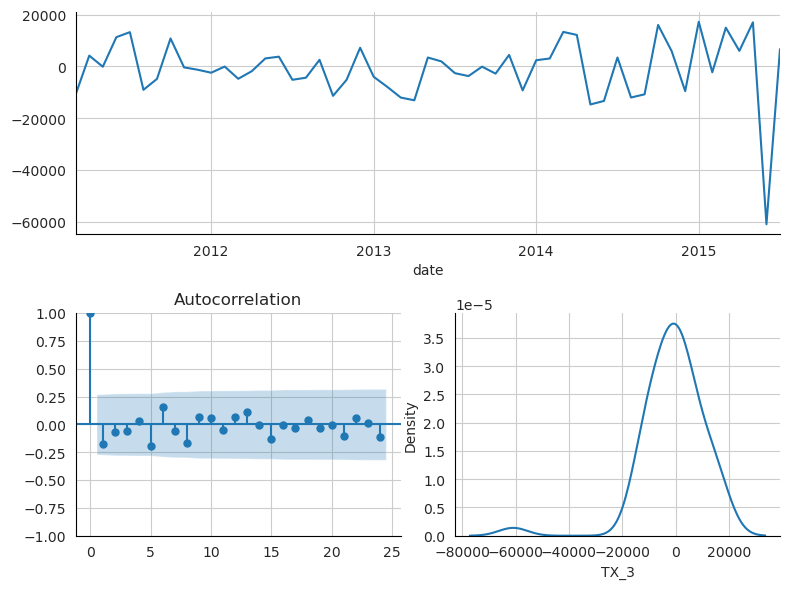

In [110]:
residual_ETSL=[(Train[i][1:]-fit_ETSL[i][1:]).dropna() for i in store_list]
for i in range(len(store_list)):
    print("\n Store Name TX_"+str(i+1))
    residualcheck(residual_ETSL[i],24);
    plt.show()

### ETS Model

In [111]:
predicted_ETS=pd.DataFrame(columns=store_list)
fit_ETS=pd.DataFrame(columns=store_list)
resid_ETS=pd.DataFrame(columns=store_list)
ETS_models=[]
for i in store_list:
    ets_AdA=sm.tsa.statespace.ExponentialSmoothing(Train[i],
                                               trend=True, 
                                               initialization_method= 'heuristic', 
                                               seasonal=12, 
                                               damped_trend=False).fit(disp=0)

    predicted_ETS[i] = ets_AdA.forecast(len(Test[i]))
    fit_ETS[i]=ets_AdA.fittedvalues
    resid_ETS[i]=Train[i]-fit_ETS[i]
    ETS_models.append(ets_AdA)

KeyError: 'TX_4'

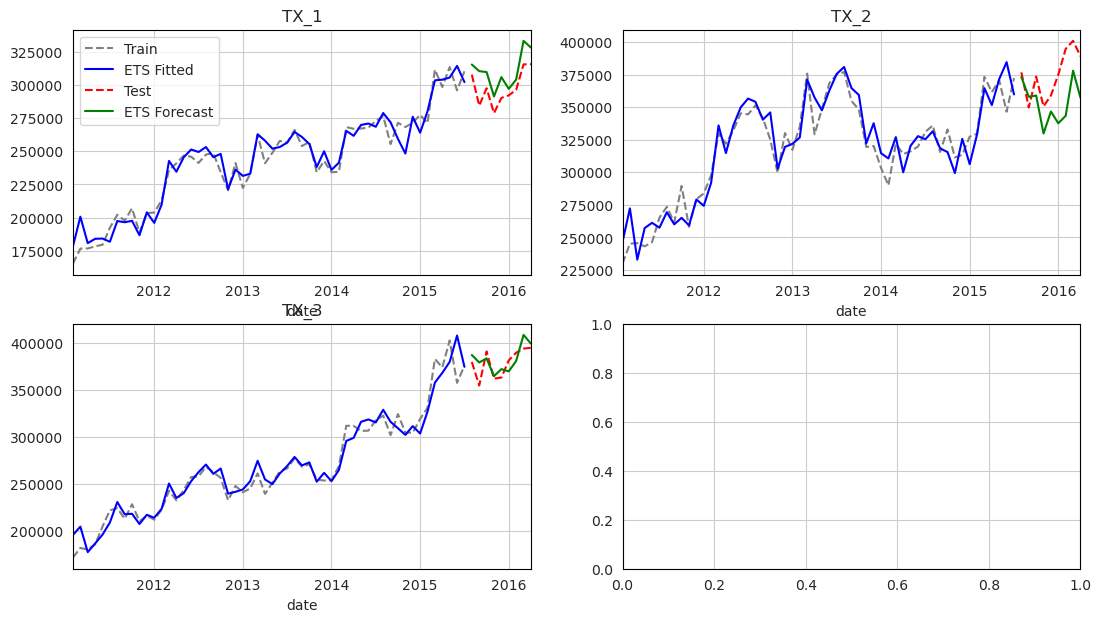

In [112]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["TX_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_ETS["TX_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="ETS Fitted",ax=axs)
    Test["TX_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_ETS["TX_"+str(i+1)].plot(color="g",legend=(i==0) ,label="ETS Forecast",ax=axs)
fig.tight_layout()

In [114]:
for i in store_list:
    model_name="ETS"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_ETS[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_ETS[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [115]:
Model_Performance

Forecast Method  MAPE     RMSE store_id
0               SARIMA Log   4.9  15740.5      NaN
1         Prophet Additive   5.9  17859.8      NaN
2   Prophet Multiplicative   5.8  18238.7      NaN
3               SARIMA Log   3.7  17449.6      NaN
4         Prophet Additive  10.1  41176.7      NaN
5   Prophet Multiplicative  10.9  44072.4      NaN
6         Prophet Additive   3.7  16779.6      NaN
7   Prophet Multiplicative   4.3  18659.8      NaN
8               SARIMA Log   3.7  25468.9      NaN
9         Holts-Winter Log   2.2   7544.2     TX_1
10    Holts-Winter Box-Cox   4.4  20157.3     TX_2
11            Holts-Winter   2.7  11795.2     TX_3
12                 ETS Log   4.5  15822.3     TX_1
13                 ETS Log   6.1  27842.3     TX_2
14                 ETS Log   3.7  17484.1     TX_3
15                     ETS   4.4  14292.7     TX_1
16                     ETS   5.9  26787.8     TX_2
17                     ETS   2.7  11788.7     TX_3



 Store Name TX_1

** Mean of the residuals:  -1236.57



** Ljung Box Test, p-value: 0.7113526223757427 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.689 (>0.05, Normal)



** AD Fuller, p_value: 1.6703041708863747e-11 (<0.05, Stationary)


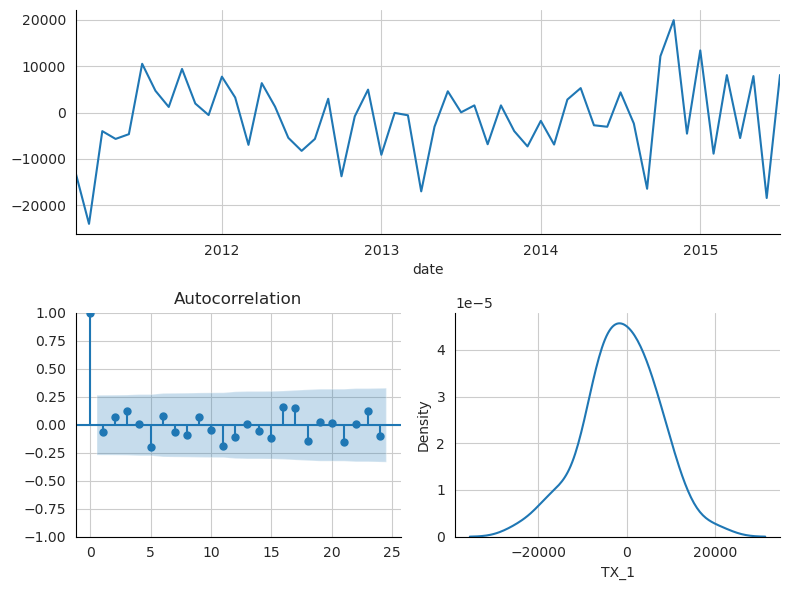



 Store Name TX_2

** Mean of the residuals:  -1807.13



** Ljung Box Test, p-value: 0.14602549525900652 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.284 (>0.05, Normal)



** AD Fuller, p_value: 1.187723791376858e-10 (<0.05, Stationary)


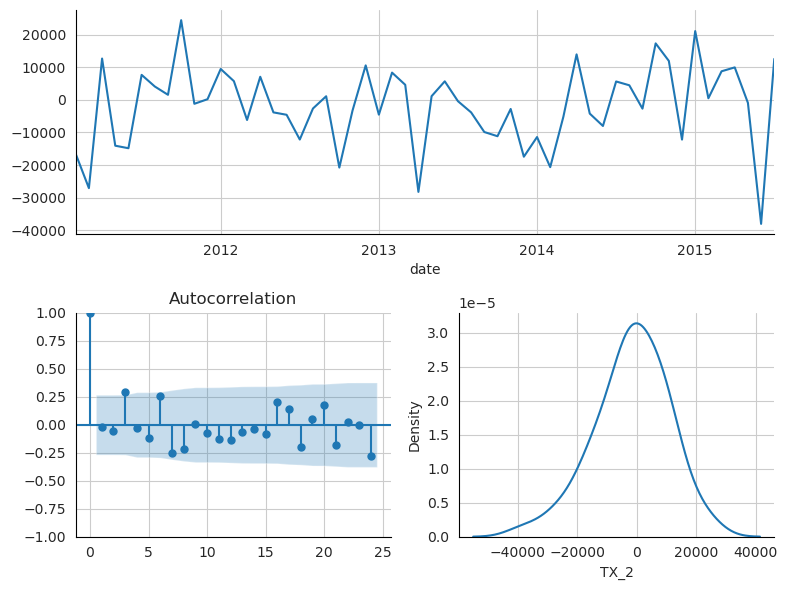



 Store Name TX_3

** Mean of the residuals:  -1195.04



** Ljung Box Test, p-value: 0.9037519872301774 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 7.40665393266115e-11 (<0.05, Stationary)


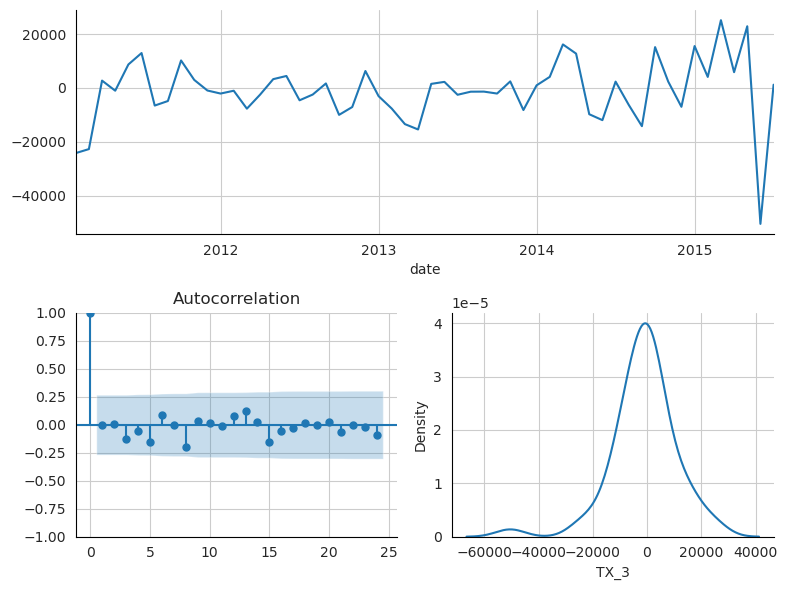

In [116]:

for i in range(len(store_list)):
    print("\n Store Name TX_"+str(i+1))
    residualcheck(resid_ETS["TX_"+str(i+1)],24);
    plt.show()

### SARIMA Models

In [117]:
best_arima=[]
for i in store_list:    
    best_arima.append(auto_arima(Train[i],
                                 seasonal=True,
                                 m=12,                         
                                 d=1,                   
                                 information_criterion='aicc'))

In [118]:
predicted_SARIMA=pd.DataFrame(columns=store_list)
fit_SARIMA=pd.DataFrame(columns=store_list)
resid_SARIMA=pd.DataFrame(columns=store_list)
for j,i in enumerate(store_list):
    sarima_model=SARIMAX(endog=Train[i],
                          **best_arima[j].get_params()
                         )
    sarima_fit=sarima_model.fit(disp=0)
    start = len(Train)
    end = len(Train) +len(Test) -1
    fit_SARIMA[i] = sarima_fit.fittedvalues
    resid_SARIMA[i] = sarima_fit.resid[1:]
    predicted_SARIMA[i] = sarima_fit.predict(start, end, dynamic=False)
    

KeyError: 'TX_4'

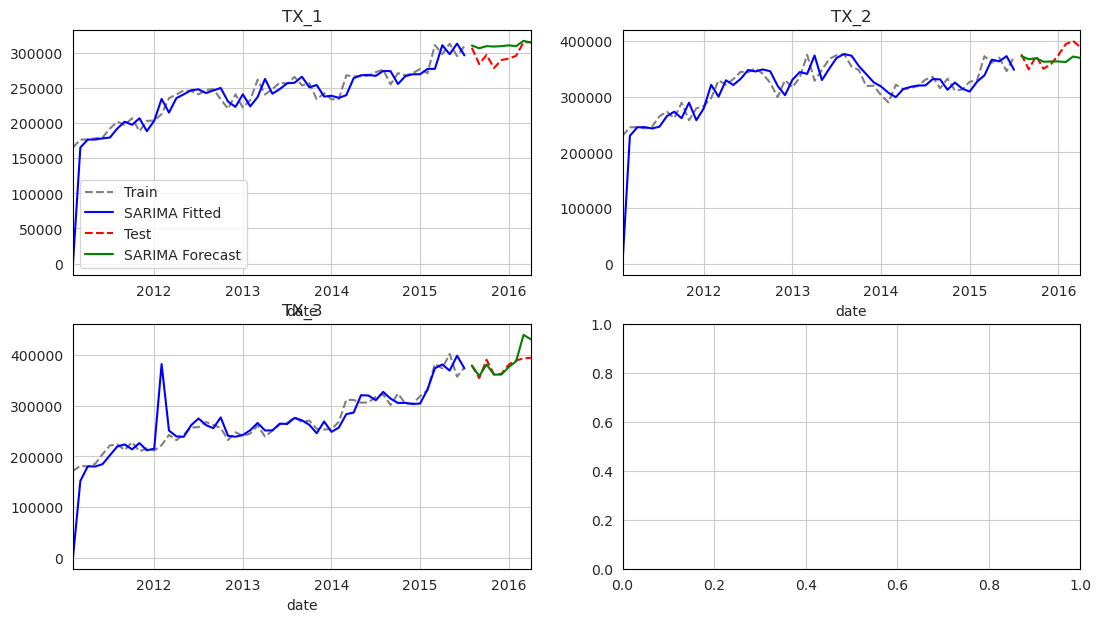

In [119]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["TX_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_SARIMA["TX_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="SARIMA Fitted",ax=axs)
    Test["TX_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_SARIMA["TX_"+str(i+1)].plot(color="g",legend=(i==0) ,label="SARIMA Forecast",ax=axs)
fig.tight_layout()

In [120]:
for i in store_list:
    model_name="SARIMA"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_SARIMA[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_SARIMA[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [121]:
Model_Performance

Forecast Method  MAPE     RMSE store_id
0               SARIMA Log   4.9  15740.5      NaN
1         Prophet Additive   5.9  17859.8      NaN
2   Prophet Multiplicative   5.8  18238.7      NaN
3               SARIMA Log   3.7  17449.6      NaN
4         Prophet Additive  10.1  41176.7      NaN
5   Prophet Multiplicative  10.9  44072.4      NaN
6         Prophet Additive   3.7  16779.6      NaN
7   Prophet Multiplicative   4.3  18659.8      NaN
8               SARIMA Log   3.7  25468.9      NaN
9         Holts-Winter Log   2.2   7544.2     TX_1
10    Holts-Winter Box-Cox   4.4  20157.3     TX_2
11            Holts-Winter   2.7  11795.2     TX_3
12                 ETS Log   4.5  15822.3     TX_1
13                 ETS Log   6.1  27842.3     TX_2
14                 ETS Log   3.7  17484.1     TX_3
15                     ETS   4.4  14292.7     TX_1
16                     ETS   5.9  26787.8     TX_2
17                     ETS   2.7  11788.7     TX_3
18                  SARIMA   4.8  16845.0     TX_1
19                  SARIMA   3.9  17790.6     TX_2
20                  SARIMA   3.0  20037.5     TX_3

In [122]:
best_arima[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   54
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -576.317
Date:                            Wed, 01 Nov 2023   AIC                           1158.633
Time:                                    01:07:01   BIC                           1164.544
Sample:                                02-01-2011   HQIC                          1160.906
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2730.2403   2068.877      1.320      0.187   -1324.683    6785.164
ar.S.L12       0.1622      0.053      3.058      0.002       0.058       0.266
sigma2      1.796e+08      0.010   1.79e+10      0.000     1.8e+08     1.8e+08
===================================================================================
Ljung-Box (L1) (Q):                  11.63   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.00   Prob(JB):                         0.94
Heteroskedasticity (H):               1.96   Skew:                             0.11
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.8e+28. Standard errors may be unstable.
"""



 Store Name TX_1

** Mean of the residuals:  1768.61



** Ljung Box Test, p-value: 0.0049482146673274505 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.977 (>0.05, Normal)



** AD Fuller, p_value: 2.6404079010362977e-21 (<0.05, Stationary)


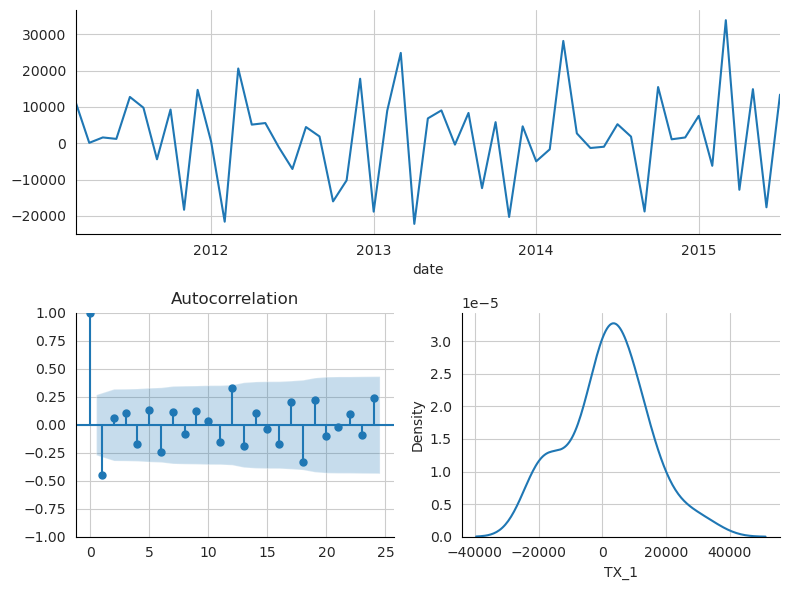



 Store Name TX_2

** Mean of the residuals:  888.96



** Ljung Box Test, p-value: 0.003124665779996817 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.782 (>0.05, Normal)



** AD Fuller, p_value: 2.8891119029925187e-19 (<0.05, Stationary)


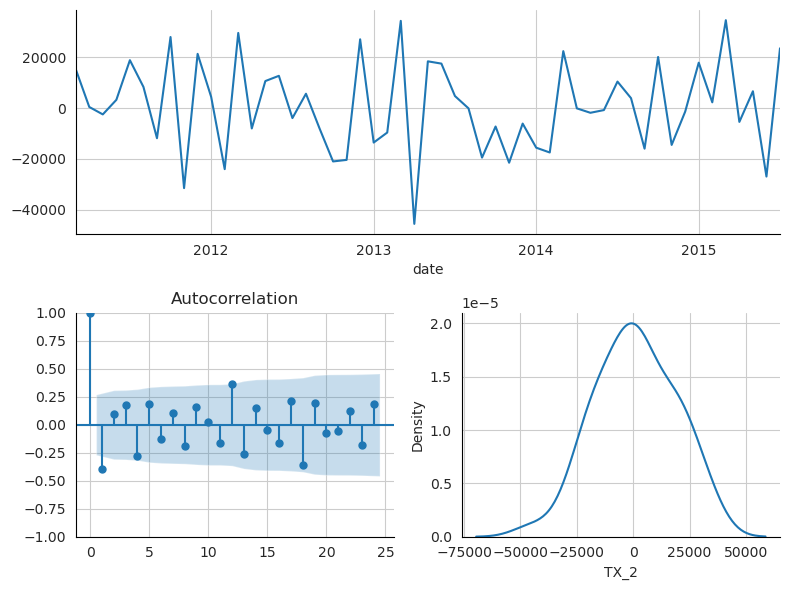



 Store Name TX_3

** Mean of the residuals:  -2006.45



** Ljung Box Test, p-value: 0.9889034098411026 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 4.386492046896506e-10 (<0.05, Stationary)


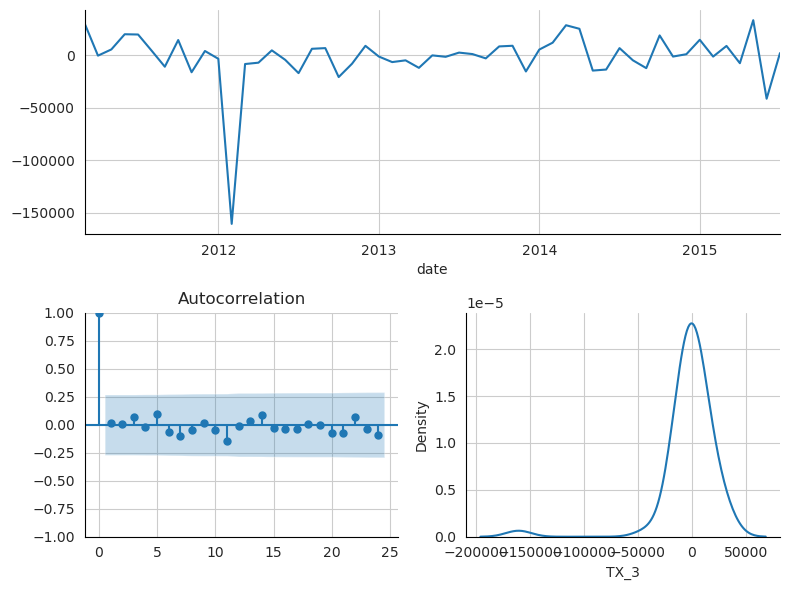

In [123]:
for i in range(len(store_list)):
    print("\n Store Name TX_"+str(i+1))
    residualcheck(resid_SARIMA["TX_"+str(i+1)],24);
    plt.show()

### SARIMA Log Models

In [124]:
best_arimaL=[]
Trainlog=np.log(Train)
for i in store_list:    
    best_arimaL.append(auto_arima(Trainlog[i],
                                 seasonal=True,
                                 m=12,                         
                                 d=1,                   
                                 information_criterion='aicc'))

In [125]:
predicted_SARIMAL=pd.DataFrame(columns=store_list)
fit_SARIMAL=pd.DataFrame(columns=store_list)
resid_SARIMAL=pd.DataFrame(columns=store_list)
for j,i in enumerate(store_list):
    sarima_model=SARIMAX(endog=Trainlog[i],
                          **best_arimaL[j].get_params()
                         )
    sarima_fit=sarima_model.fit(disp=0)
    start = len(Train)
    end = len(Train) +len(Test) -1
    fit_SARIMAL[i] = np.exp(sarima_fit.fittedvalues)
    resid_SARIMAL[i] = Train[i][1:]-fit_SARIMAL[i][1:]
    predicted_SARIMAL[i] = np.exp(sarima_fit.predict(start, end, dynamic=False))

KeyError: 'TX_4'

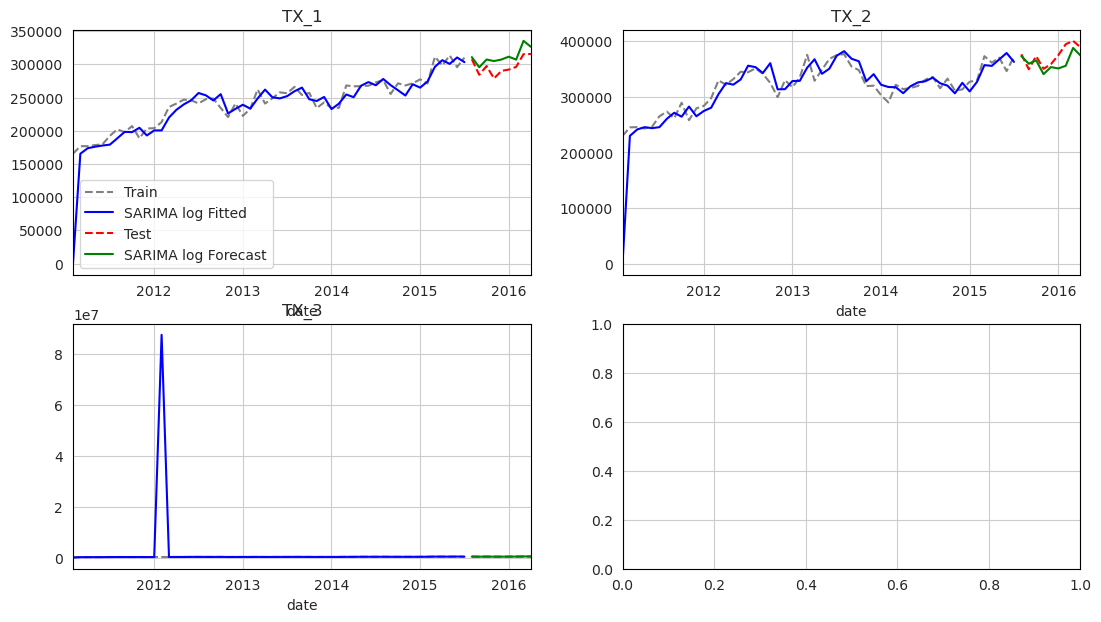

In [126]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["TX_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_SARIMAL["TX_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="SARIMA log Fitted",ax=axs)
    Test["TX_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_SARIMAL["TX_"+str(i+1)].plot(color="g",legend=(i==0) ,label="SARIMA log Forecast",ax=axs)
fig.tight_layout()

In [127]:
for i in store_list:
    model_name="SARIMA Log"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_SARIMAL[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_SARIMAL[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [128]:
Model_Performance

Forecast Method  MAPE     RMSE store_id
0               SARIMA Log   4.9  15740.5      NaN
1         Prophet Additive   5.9  17859.8      NaN
2   Prophet Multiplicative   5.8  18238.7      NaN
3               SARIMA Log   3.7  17449.6      NaN
4         Prophet Additive  10.1  41176.7      NaN
5   Prophet Multiplicative  10.9  44072.4      NaN
6         Prophet Additive   3.7  16779.6      NaN
7   Prophet Multiplicative   4.3  18659.8      NaN
8               SARIMA Log   3.7  25468.9      NaN
9         Holts-Winter Log   2.2   7544.2     TX_1
10    Holts-Winter Box-Cox   4.4  20157.3     TX_2
11            Holts-Winter   2.7  11795.2     TX_3
12                 ETS Log   4.5  15822.3     TX_1
13                 ETS Log   6.1  27842.3     TX_2
14                 ETS Log   3.7  17484.1     TX_3
15                     ETS   4.4  14292.7     TX_1
16                     ETS   5.9  26787.8     TX_2
17                     ETS   2.7  11788.7     TX_3
18                  SARIMA   4.8  16845.0     TX_1
19                  SARIMA   3.9  17790.6     TX_2
20                  SARIMA   3.0  20037.5     TX_3
21              SARIMA Log   4.9  15740.5     TX_1
22              SARIMA Log   3.7  17449.6     TX_2
23              SARIMA Log   3.7  25468.9     TX_3



 Store Name TX_1

** Mean of the residuals:  1724.61



** Ljung Box Test, p-value: 0.7154100473732775 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.172 (>0.05, Normal)



** AD Fuller, p_value: 3.9083318102678454e-12 (<0.05, Stationary)


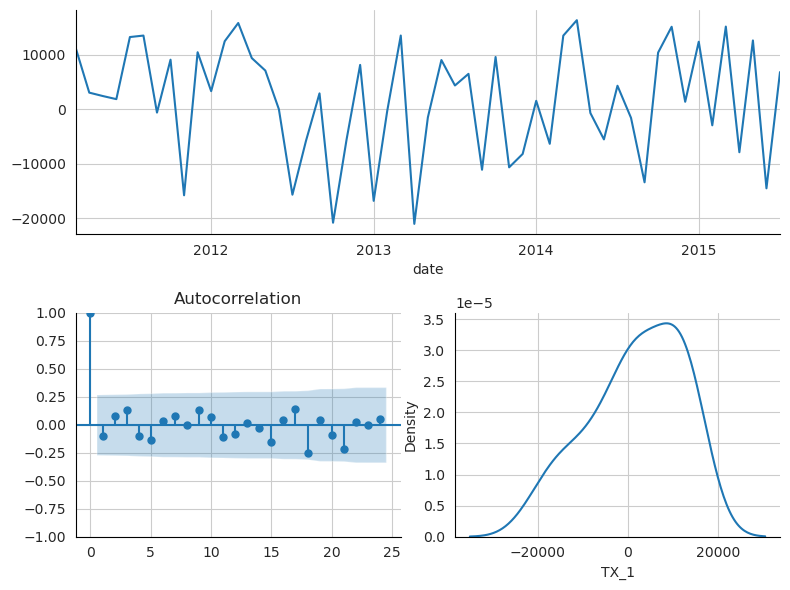



 Store Name TX_2

** Mean of the residuals:  -22.12



** Ljung Box Test, p-value: 0.6169732930354644 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.209 (>0.05, Normal)



** AD Fuller, p_value: 0.04689755436922669 (<0.05, Stationary)


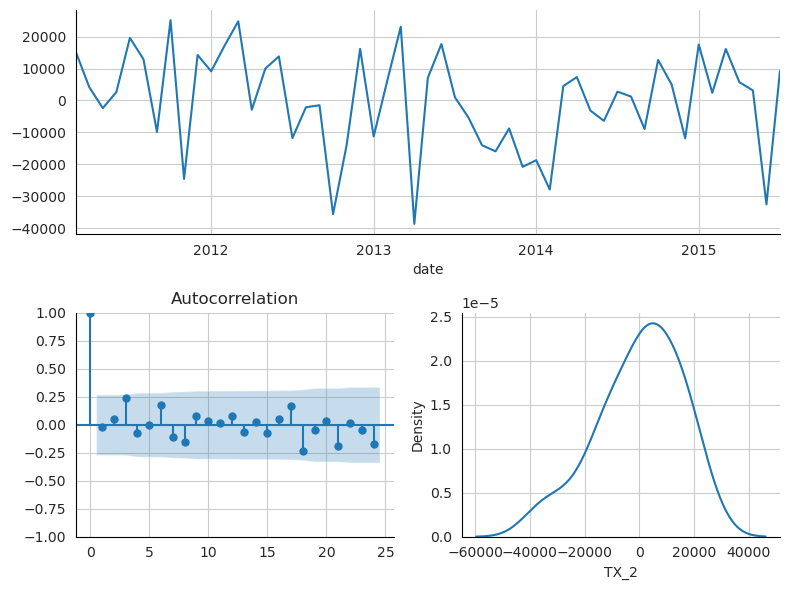



 Store Name TX_3

** Mean of the residuals:  -1649339.37



** Ljung Box Test, p-value: 0.9939706475794944 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 2.2309873305401316e-10 (<0.05, Stationary)


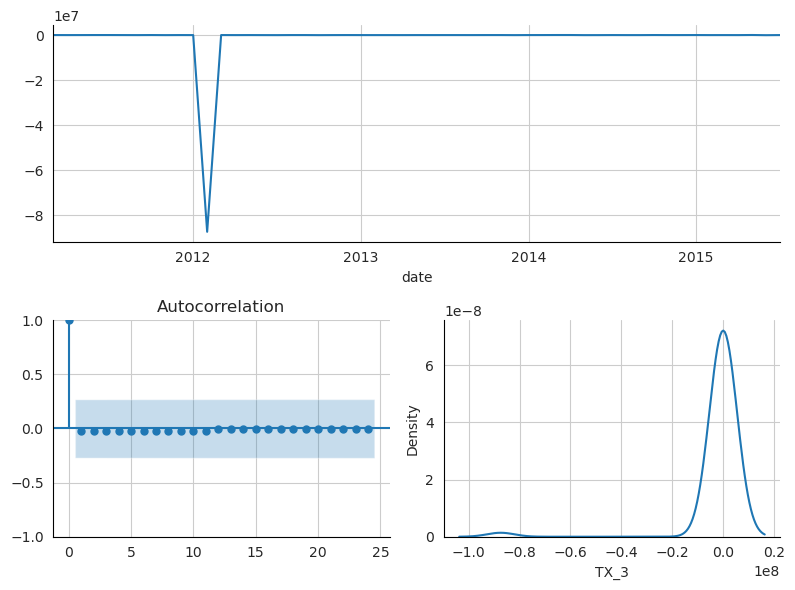

In [129]:
for i in range(len(store_list)):
    print("\n Store Name TX_"+str(i+1))
    residualcheck(resid_SARIMAL["TX_"+str(i+1)],24);
    plt.show()

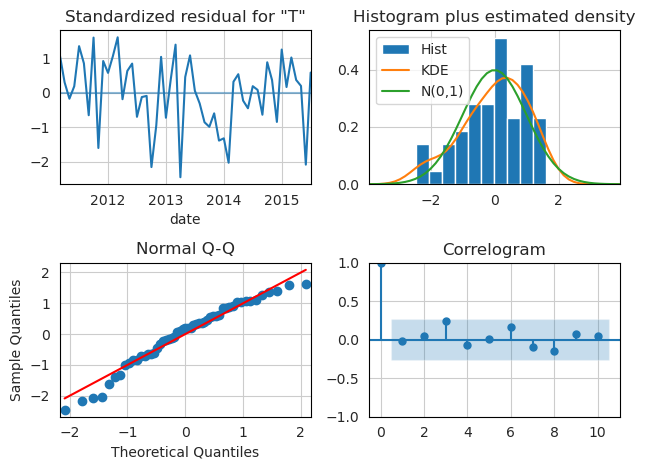

In [130]:
SARIMAX(endog=Trainlog["TX_2"],**best_arimaL[1].get_params()).fit(disp=0).plot_diagnostics()
plt.tight_layout()
plt.show()

### FB Prophet Model

In [131]:
import os
import sys

class suppress_stdout_stderr(object):
    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])


In [132]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

predicted_prophet_add=pd.DataFrame(columns=store_list)
fit_prophet_add=pd.DataFrame(columns=store_list)
resid_prophet_add=pd.DataFrame(columns=store_list)

predicted_prophet_mul=pd.DataFrame(columns=store_list)
fit_prophet_mul=pd.DataFrame(columns=store_list)
resid_prophet_mul=pd.DataFrame(columns=store_list)

prophetmodels=[]

for i in store_list:
    train_fb_prophet=Train[i].reset_index()
    train_fb_prophet.columns=["ds","y"]  
    test_fb_prophet=Test[i].reset_index()
    test_fb_prophet.columns=["ds","y"]
    seasonality_mode=["multiplicative","additive"]
    for j in seasonality_mode:
        with suppress_stdout_stderr(): 
            prophet_model=Prophet(weekly_seasonality=False,
                                  daily_seasonality=False,
                                  yearly_seasonality=True,
                                  seasonality_mode=j).fit(train_fb_prophet)
        fb_dataframe=prophet_model.make_future_dataframe(len(Test),freq='MS',include_history=True)
        predicted_prophet=prophet_model.predict(fb_dataframe).set_index("ds")
        if j=="multiplicative":
            predicted_prophet_mul[i]=predicted_prophet[Test.index[0]:]["yhat"]
            fit_prophet_mul[i]=predicted_prophet[:Train.index[-1]]["yhat"]
            resid_prophet_mul[i]=Train[i]-fit_prophet_mul[i]
        else:
            predicted_prophet_add[i]=predicted_prophet[Test.index[0]:]["yhat"]
            fit_prophet_add[i]=predicted_prophet[:Train.index[-1]]["yhat"]
            resid_prophet_add[i]=Train[i]-fit_prophet_add[i]
            prophetmodels.append(prophet_model)


01:07:33 - cmdstanpy - INFO - Chain [1] start processing

01:07:34 - cmdstanpy - INFO - Chain [1] done processing

01:07:34 - cmdstanpy - INFO - Chain [1] start processing

01:07:34 - cmdstanpy - INFO - Chain [1] done processing

01:07:34 - cmdstanpy - INFO - Chain [1] start processing

01:07:35 - cmdstanpy - INFO - Chain [1] done processing

01:07:35 - cmdstanpy - INFO - Chain [1] start processing

01:07:35 - cmdstanpy - INFO - Chain [1] done processing

01:07:35 - cmdstanpy - INFO - Chain [1] start processing

01:07:36 - cmdstanpy - INFO - Chain [1] done processing

01:07:36 - cmdstanpy - INFO - Chain [1] start processing

01:07:36 - cmdstanpy - INFO - Chain [1] done processing


KeyError: 'TX_4'

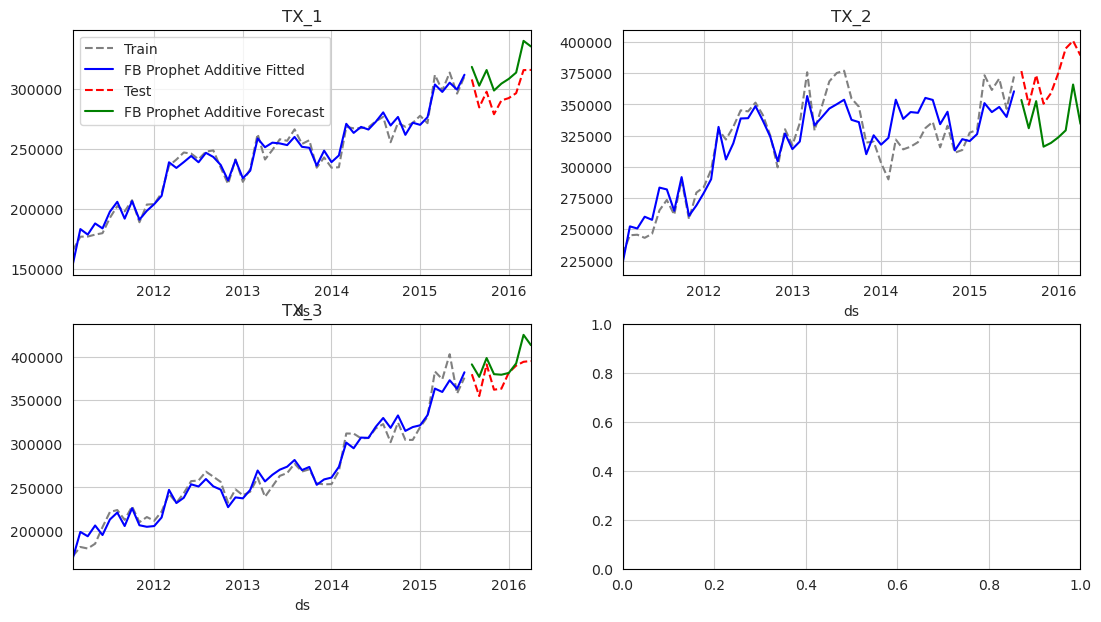

In [133]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["TX_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_prophet_add["TX_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="FB Prophet Additive Fitted",ax=axs)
    Test["TX_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_prophet_add["TX_"+str(i+1)].plot(color="g",legend=(i==0) ,label="FB Prophet Additive Forecast",ax=axs)
fig.tight_layout()

In [134]:
for i in store_list:
    model_name="Prophet Additive"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_prophet_add[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_prophet_add[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

KeyError: 'TX_4'

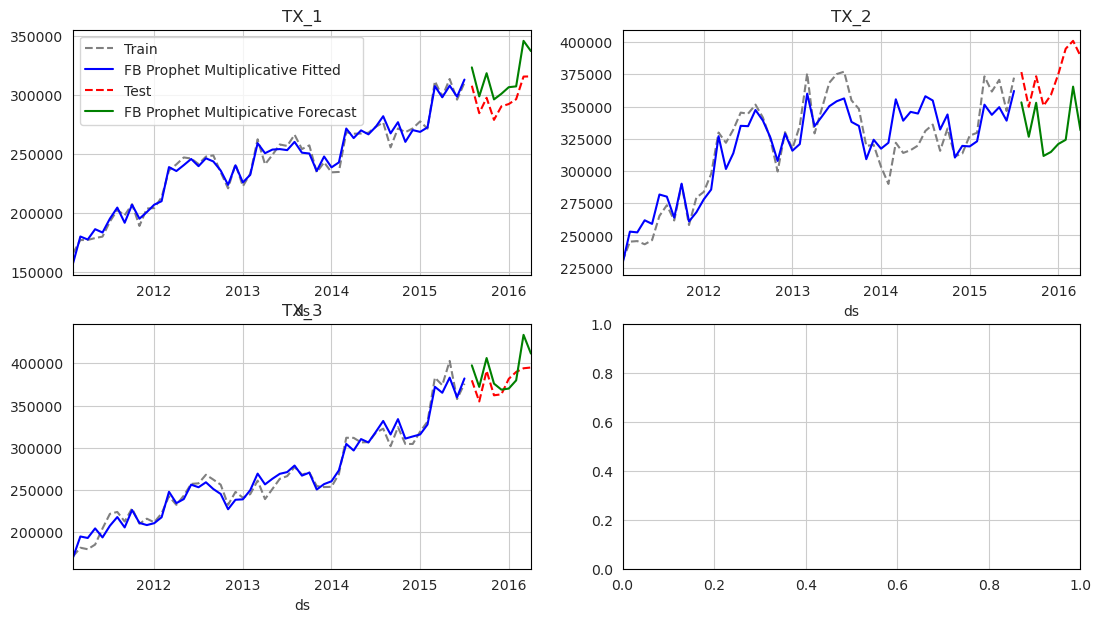

In [135]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["TX_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_prophet_mul["TX_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="FB Prophet Multiplicative Fitted",ax=axs)
    Test["TX_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_prophet_mul["TX_"+str(i+1)].plot(color="g",legend=(i==0) ,label="FB Prophet Multipicative Forecast",ax=axs)
fig.tight_layout()

In [136]:
for i in store_list:
    model_name="Prophet Multiplicative"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_prophet_mul[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_prophet_mul[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [137]:
Model_Performance

Forecast Method  MAPE     RMSE store_id
0               SARIMA Log   4.9  15740.5      NaN
1         Prophet Additive   5.9  17859.8      NaN
2   Prophet Multiplicative   5.8  18238.7      NaN
3               SARIMA Log   3.7  17449.6      NaN
4         Prophet Additive  10.1  41176.7      NaN
5   Prophet Multiplicative  10.9  44072.4      NaN
6         Prophet Additive   3.7  16779.6      NaN
7   Prophet Multiplicative   4.3  18659.8      NaN
8               SARIMA Log   3.7  25468.9      NaN
9         Holts-Winter Log   2.2   7544.2     TX_1
10    Holts-Winter Box-Cox   4.4  20157.3     TX_2
11            Holts-Winter   2.7  11795.2     TX_3
12                 ETS Log   4.5  15822.3     TX_1
13                 ETS Log   6.1  27842.3     TX_2
14                 ETS Log   3.7  17484.1     TX_3
15                     ETS   4.4  14292.7     TX_1
16                     ETS   5.9  26787.8     TX_2
17                     ETS   2.7  11788.7     TX_3
18                  SARIMA   4.8  16845.0     TX_1
19                  SARIMA   3.9  17790.6     TX_2
20                  SARIMA   3.0  20037.5     TX_3
21              SARIMA Log   4.9  15740.5     TX_1
22              SARIMA Log   3.7  17449.6     TX_2
23              SARIMA Log   3.7  25468.9     TX_3
24        Prophet Additive   5.9  17859.8     TX_1
25        Prophet Additive  10.1  41176.7     TX_2
26        Prophet Additive   3.7  16779.6     TX_3
27  Prophet Multiplicative   5.8  18238.7     TX_1
28  Prophet Multiplicative  10.9  44072.4     TX_2
29  Prophet Multiplicative   4.3  18659.8     TX_3



 Store Name TX_1

** Mean of the residuals:  0.74



** Ljung Box Test, p-value: 0.550815557317499 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.757 (>0.05, Normal)



** AD Fuller, p_value: 1.0106340910123533e-08 (<0.05, Stationary)


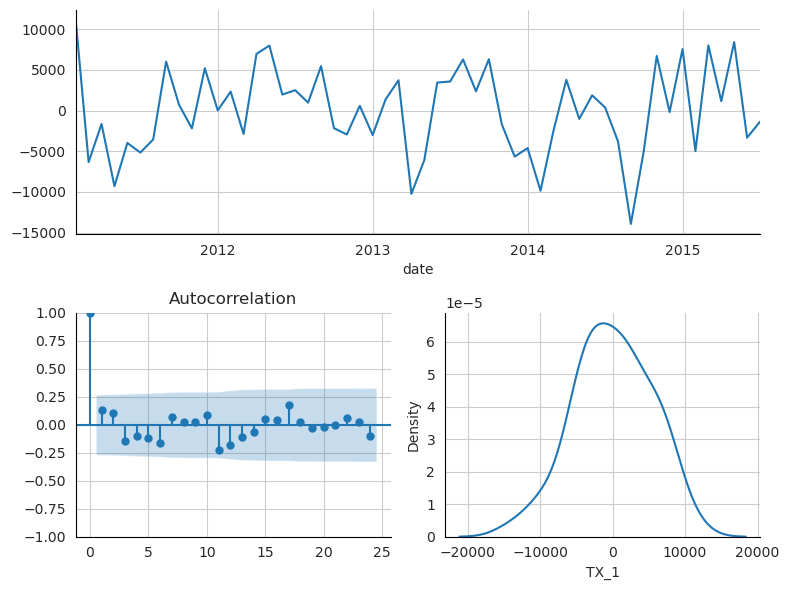



 Store Name TX_2

** Mean of the residuals:  1.83



** Ljung Box Test, p-value: 4.615766079355948e-11 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.361 (>0.05, Normal)



** AD Fuller, p_value: 0.190075677211959 (>0.05, Non-stationary)


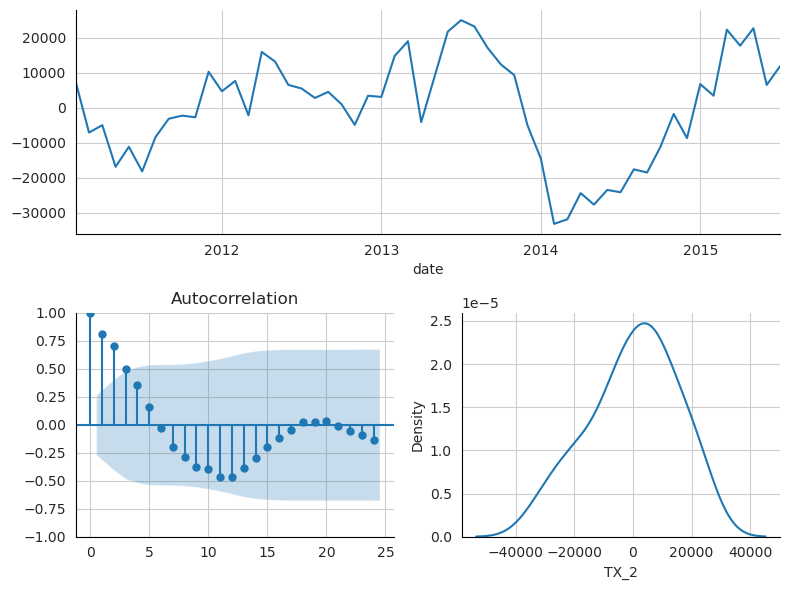



 Store Name TX_3

** Mean of the residuals:  5.42



** Ljung Box Test, p-value: 0.005406565927301587 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.665 (>0.05, Normal)



** AD Fuller, p_value: 0.0003255878740548694 (<0.05, Stationary)


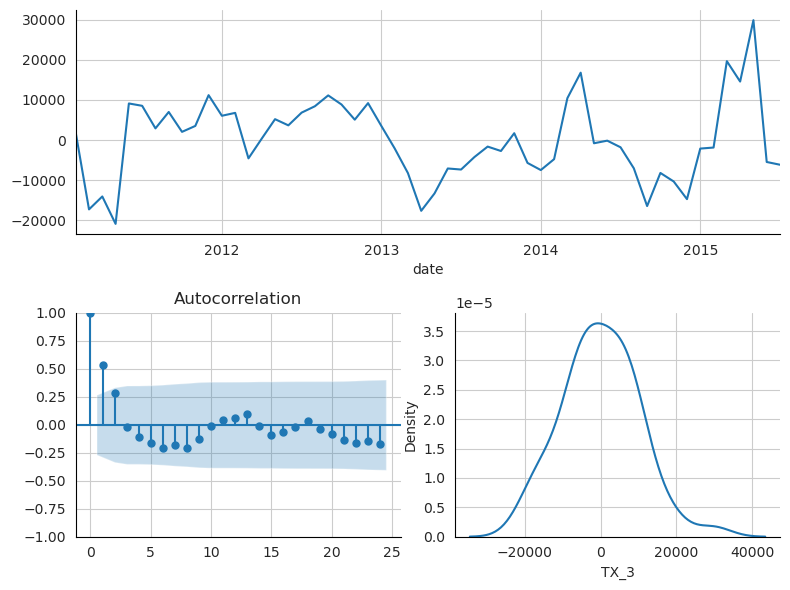

In [138]:
for i in range(len(store_list)):
    print("\n Store Name TX_"+str(i+1))
    residualcheck(resid_prophet_add["TX_"+str(i+1)],24);
    plt.show()



 Store Name TX_1

** Mean of the residuals:  5.47



** Ljung Box Test, p-value: 0.3253518455505985 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.737 (>0.05, Normal)



** AD Fuller, p_value: 4.724153684862744e-08 (<0.05, Stationary)


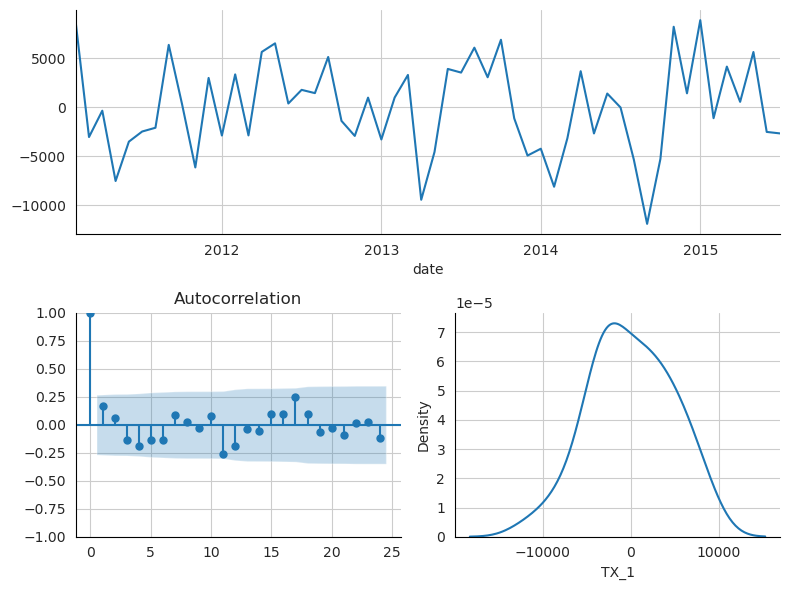



 Store Name TX_2

** Mean of the residuals:  28.62



** Ljung Box Test, p-value: 1.4402539359825073e-11 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.215 (>0.05, Normal)



** AD Fuller, p_value: 0.24982907459601372 (>0.05, Non-stationary)


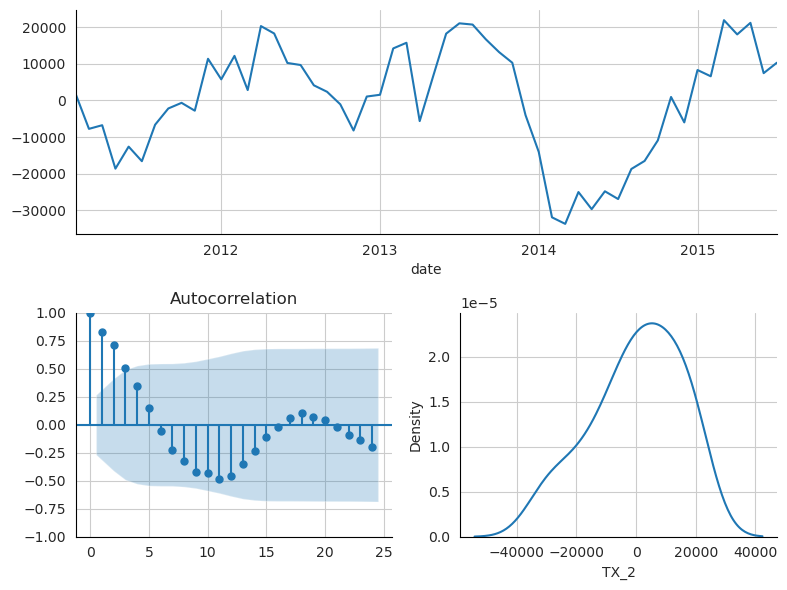



 Store Name TX_3

** Mean of the residuals:  28.84



** Ljung Box Test, p-value: 0.0010159455575577787 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.812 (>0.05, Normal)



** AD Fuller, p_value: 0.0024730184519701315 (<0.05, Stationary)


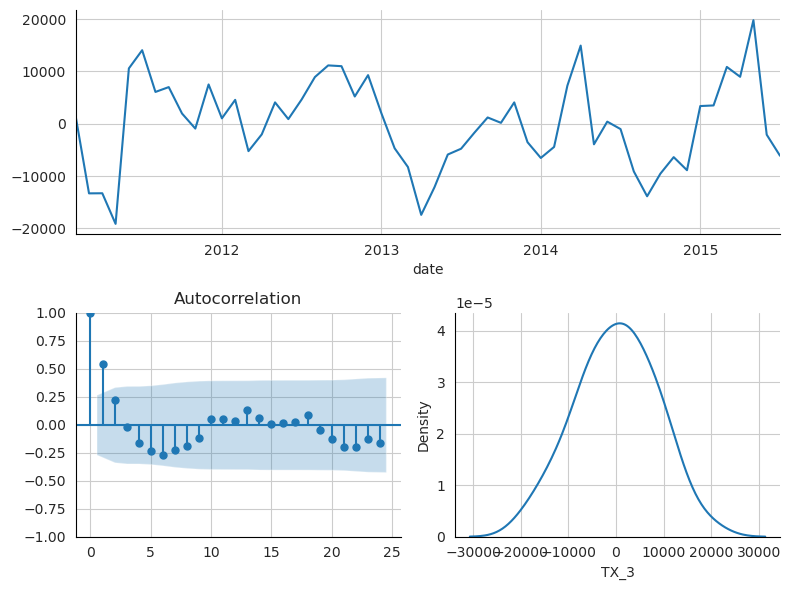

In [139]:
for i in range(len(store_list)):
    print("\n Store Name TX_"+str(i+1))
    residualcheck(resid_prophet_mul["TX_"+str(i+1)],24);
    plt.show()

### Summary Best Model

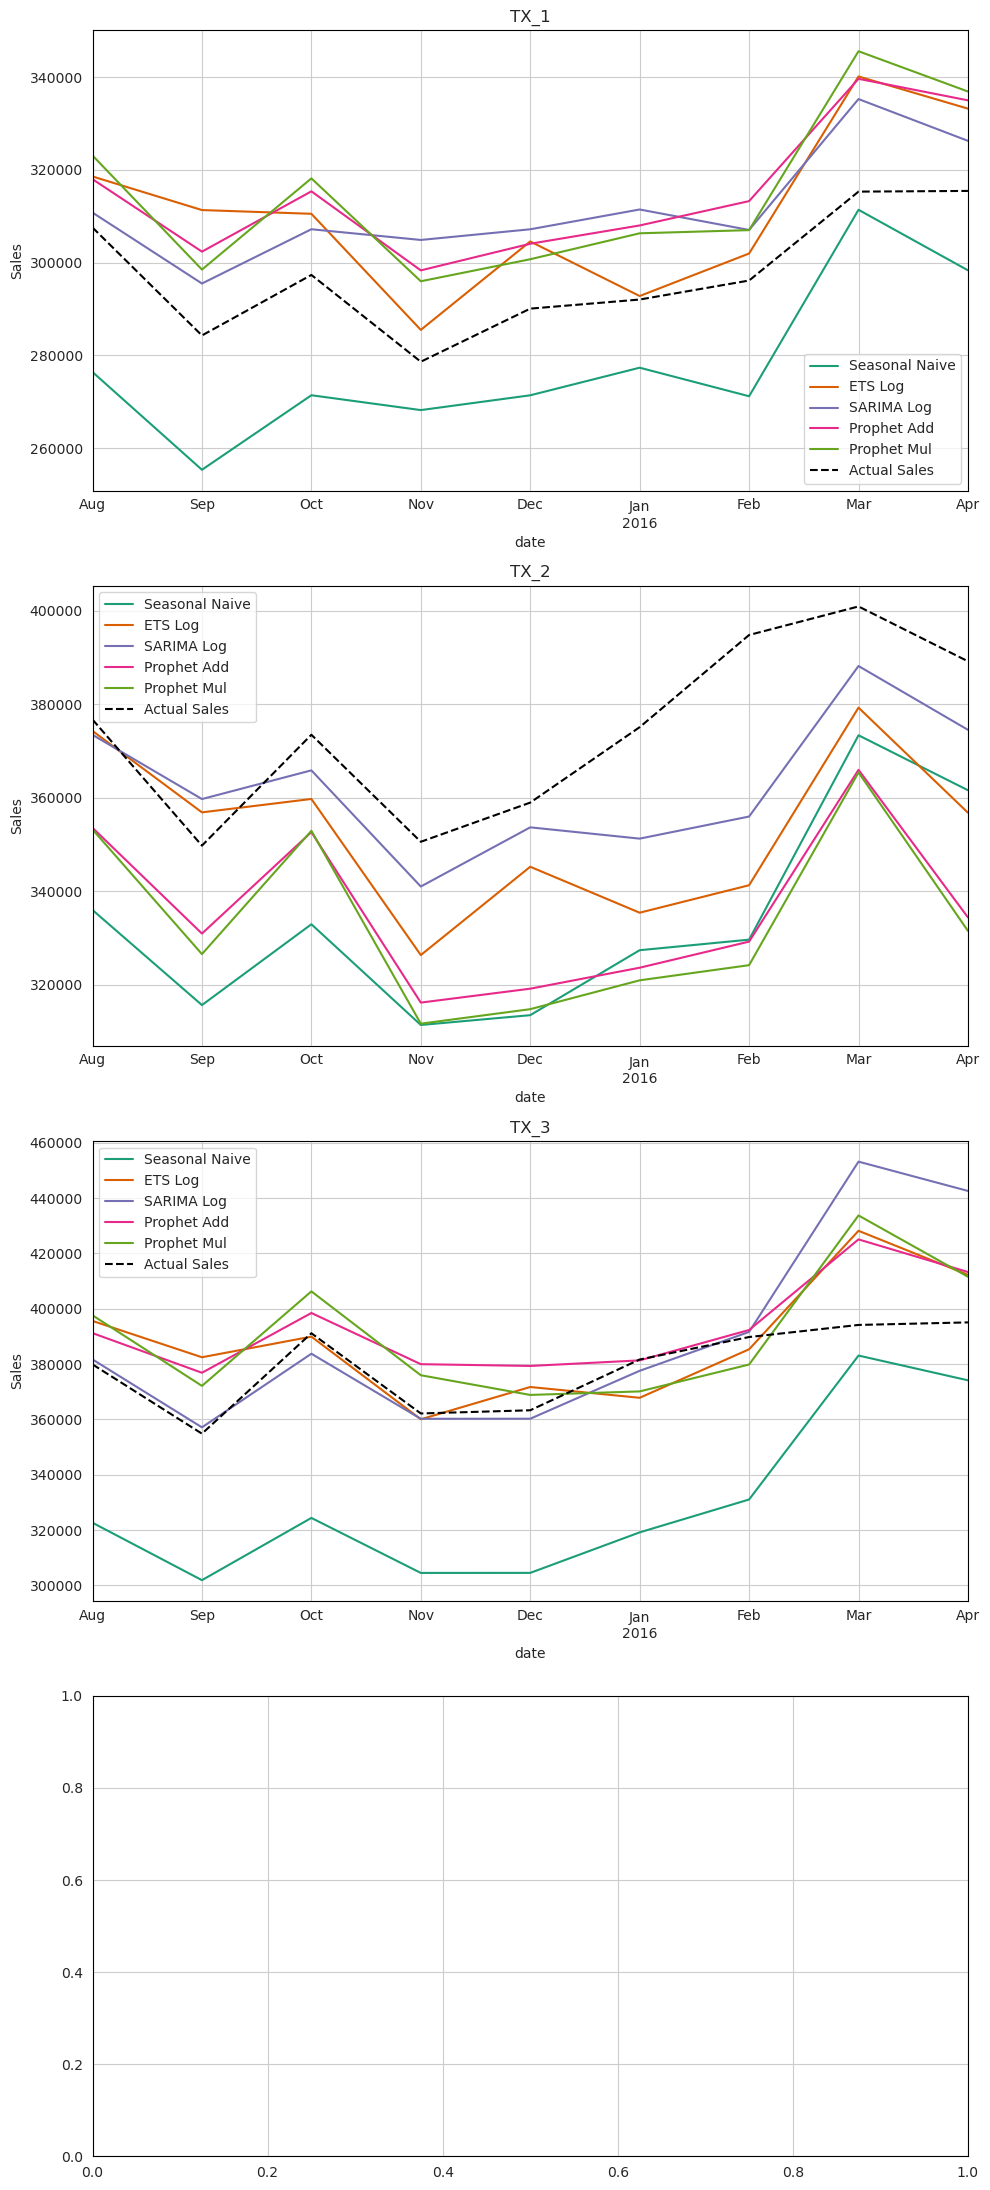

In [140]:
fig,axs=plt.subplots(figsize=(10,22),nrows=4,ncols=1)
for j,i in enumerate(store_list):   
    axs[j].set_prop_cycle(cycler('color', plt.cm.Dark2.colors))
    predicted_naive[i].plot(legend=True, label="Seasonal Naive",ax=axs[j]).set_title(i)
    #predicted_HW[i].plot(legend=True, label="Holts Winter",ax=axs[j])
    #predicted_ETS[i].plot(legend=True, label="ETS",ax=axs[j])
    predicted_ETSL[i].plot(legend=True, label="ETS Log",ax=axs[j])
    #predicted_SARIMA[i].plot(legend=True, label="SARIMA",ax=axs[j])
    predicted_SARIMAL[i].plot(legend=True, label="SARIMA Log",ax=axs[j])
    predicted_prophet_add[i].plot(legend=True, label="Prophet Add",ax=axs[j])
    predicted_prophet_mul[i].plot(legend=True, label="Prophet Mul",ax=axs[j])
    Test[i].plot(color="black",label="Actual Sales",style="--",legend=True,ax=axs[j])
    #axs[j].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axs[j].set_ylabel("Sales")
    axs[j].grid(which='minor')
fig.tight_layout()


In [141]:
Model_Performance.sort_values(by=["store_id","RMSE","MAPE"],inplace=True)
Model_Performance.set_index("store_id",inplace=True)

1. **TX_1**

In [142]:
Model_Performance.loc["TX_1"]

Forecast Method  MAPE     RMSE
store_id                                       
TX_1            Holts-Winter Log   2.2   7544.2
TX_1                         ETS   4.4  14292.7
TX_1                  SARIMA Log   4.9  15740.5
TX_1                     ETS Log   4.5  15822.3
TX_1                      SARIMA   4.8  16845.0
TX_1            Prophet Additive   5.9  17859.8
TX_1      Prophet Multiplicative   5.8  18238.7

In [143]:
HW_model_best.loc["TX_1"]

Trend                        add
Seasonal                     add
Damped                      True
Box_Cox                      log
AICc_Train                -328.5
MAPE_Train                   2.3
RMSE_Train                6926.0
MAPE_Test                    2.2
RMSE_Test                 7544.2
lj_residual         Uncorrelated
jb_norm_residual          Normal
resid_mean                 214.4
Name: TX_1, dtype: object

In [145]:
CA1_model=ExponentialSmoothing(np.log(CA_monthly["TX_1"]),
                     trend=HW_model_best.loc["TX_1"].Trend,
                     seasonal=HW_model_best.loc["TX_1"].Seasonal,
                     damped_trend=HW_model_best.loc["TX_1"].Damped,
                     seasonal_periods=12,
                     use_boxcox=False,
                     initialization_method="heuristic",
                     freq='MS').fit()
fit_CA1=np.exp(CA1_model.fittedvalues)
predicted_CA1=np.exp(CA1_model.forecast(6))
sim_frame_CA1=CA1_model.simulate(6, anchor='end',repetitions=5000 ).T.apply(np.exp).round(1)

In [146]:
percentile_CA1=pd.DataFrame(columns=["2.5th_percentile","97.5th_percentile"],index=sim_frame_CA1.columns)
for i in sim_frame_CA1.columns:
    percentile_CA1.loc[i,"2.5th_percentile"]=np.quantile(sim_frame_CA1[i],0.025).round(1)
    percentile_CA1.loc[i,"97.5th_percentile"]=np.quantile(sim_frame_CA1[i],0.975).round(1) 

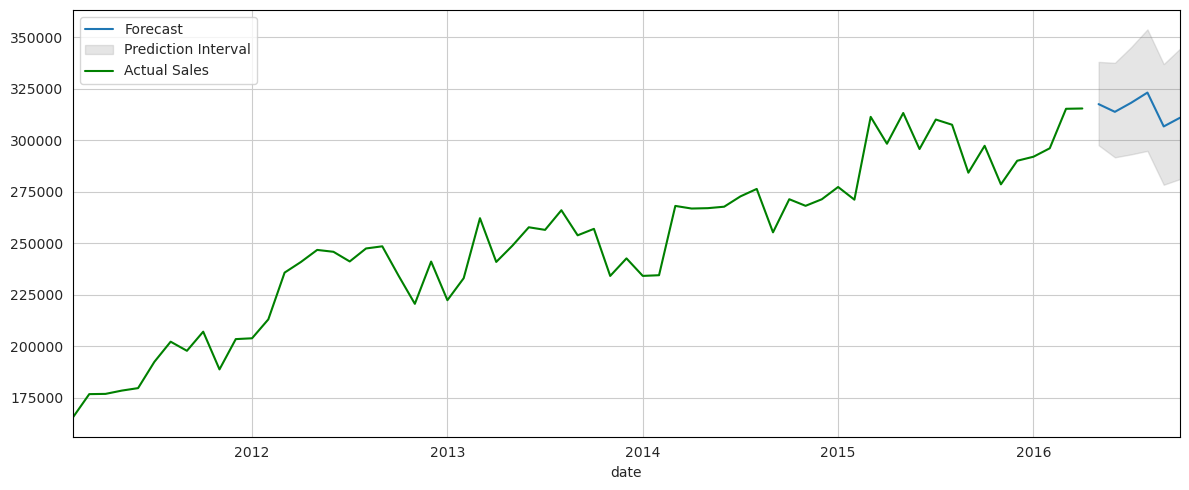

In [147]:
percentile_CA1["97.5th_percentile"]=percentile_CA1["97.5th_percentile"].astype(int)
percentile_CA1["2.5th_percentile"]=percentile_CA1["2.5th_percentile"].astype(int)
fig, ax = plt.subplots(figsize=(12,5),nrows=1,ncols=1)
predicted_CA1.plot(ax=ax, legend=True, label="Forecast" )
ax.fill_between(percentile_CA1.index,y1=percentile_CA1["2.5th_percentile"],y2=percentile_CA1["97.5th_percentile"],label="Prediction Interval", alpha=0.2,color='gray')
CA_monthly["TX_1"].plot(legend=True, label="Actual Sales",color="green", ax=ax);
ax.legend(loc="upper left")
fig.tight_layout()

1. **TX_2**

In [148]:
Model_Performance.loc["TX_2"]

Forecast Method  MAPE     RMSE
store_id                                       
TX_2                  SARIMA Log   3.7  17449.6
TX_2                      SARIMA   3.9  17790.6
TX_2        Holts-Winter Box-Cox   4.4  20157.3
TX_2                         ETS   5.9  26787.8
TX_2                     ETS Log   6.1  27842.3
TX_2            Prophet Additive  10.1  41176.7
TX_2      Prophet Multiplicative  10.9  44072.4

In [160]:
CA2_model=sm.tsa.statespace.ExponentialSmoothing(np.log(CA_monthly["TX_2"]),
                                               trend=True, 
                                               initialization_method= 'heuristic', 
                                               seasonal=12, 
                                               damped_trend=False).fit(disp=0)
fit_CA2=np.exp(CA2_model.fittedvalues)
predicted_CA2=np.exp(CA2_model.forecast(6))
sim_frame_CA2=CA2_model.simulate(6, anchor='end',repetitions=5000 ).T.apply(np.exp).round(1)

In [161]:
percentile_CA2=pd.DataFrame(columns=["2.5th_percentile","97.5th_percentile"],index=sim_frame_CA2.columns)
for i in sim_frame_CA2.columns:
    percentile_CA2.loc[i,"2.5th_percentile"]=np.quantile(sim_frame_CA2[i],0.025).round(1)
    percentile_CA2.loc[i,"97.5th_percentile"]=np.quantile(sim_frame_CA2[i],0.975).round(1) 

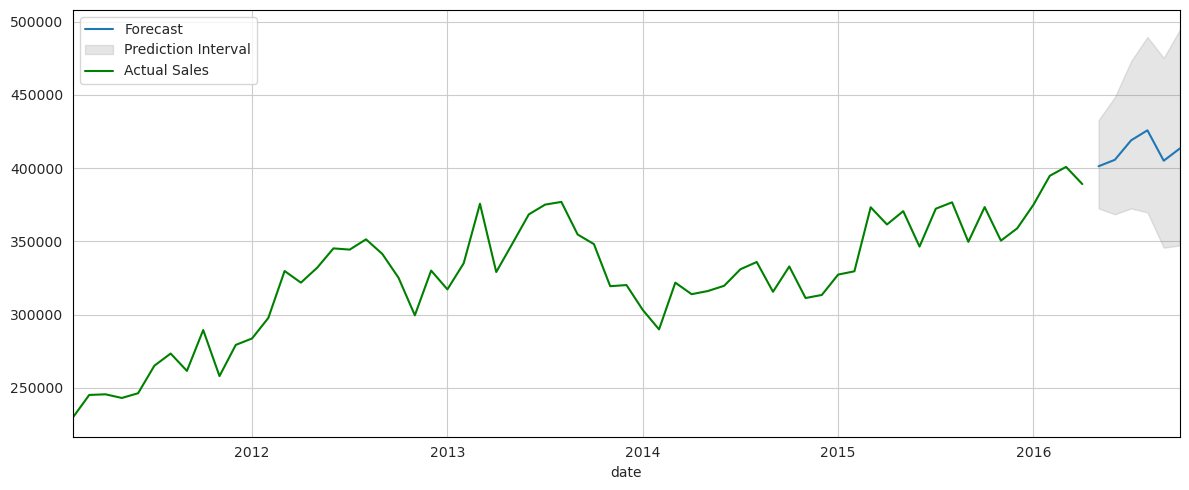

In [162]:
percentile_CA2["97.5th_percentile"]=percentile_CA2["97.5th_percentile"].astype(int)
percentile_CA2["2.5th_percentile"]=percentile_CA2["2.5th_percentile"].astype(int)
fig, ax = plt.subplots(figsize=(12,5),nrows=1,ncols=1)
predicted_CA2.plot(ax=ax, legend=True, label="Forecast" )
ax.fill_between(percentile_CA2.index,y1=percentile_CA2["2.5th_percentile"],y2=percentile_CA2["97.5th_percentile"],label="Prediction Interval", alpha=0.2,color='gray')
CA_monthly["TX_2"].plot(legend=True, label="Actual Sales",color="green", ax=ax);
ax.legend(loc="upper left")
fig.tight_layout()

In [163]:
t1=CA2_model.get_forecast(6)
t2=t1.summary_frame(alpha=0.05).apply(np.exp)[["mean","mean_ci_lower","mean_ci_upper"]]

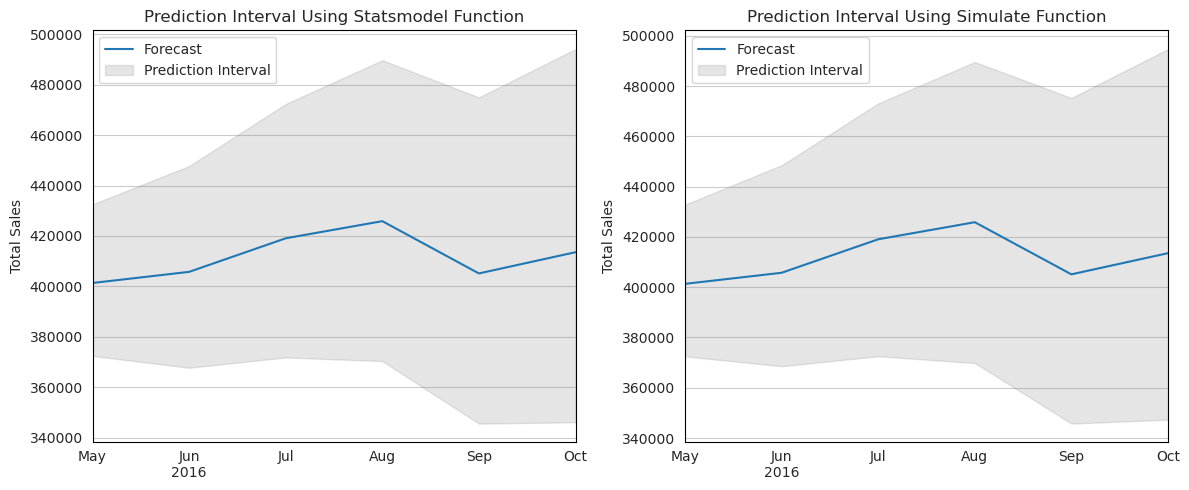

In [164]:
fig, (ax,ax2) = plt.subplots(figsize=(12,5),nrows=1,ncols=2)
predicted_CA2.plot(ax=ax, legend=True, label="Forecast" )
ax.fill_between(percentile_CA2.index,y1=t2.mean_ci_lower,y2=t2.mean_ci_upper,label="Prediction Interval", alpha=0.2,color='gray')
ax.legend(loc="upper left")
ax.set_title("Prediction Interval Using Statsmodel Function")
ax.set_ylabel("Total Sales")
predicted_CA2.plot(ax=ax2, legend=True, label="Forecast" )
ax2.fill_between(percentile_CA2.index,y1=percentile_CA2["2.5th_percentile"],y2=percentile_CA2["97.5th_percentile"],label="Prediction Interval", alpha=0.2,color='gray')
ax2.legend(loc="upper left")
ax2.set_title("Prediction Interval Using Simulate Function")
ax2.set_ylabel("Total Sales")
fig.tight_layout()

1. **TX_3**

In [165]:
Model_Performance.loc["TX_3"]

Forecast Method  MAPE     RMSE
store_id                                       
TX_3                         ETS   2.7  11788.7
TX_3                Holts-Winter   2.7  11795.2
TX_3            Prophet Additive   3.7  16779.6
TX_3                     ETS Log   3.7  17484.1
TX_3      Prophet Multiplicative   4.3  18659.8
TX_3                      SARIMA   3.0  20037.5
TX_3                  SARIMA Log   3.7  25468.9

In [167]:
print("Holts Winter AICc:",HW_model_best.loc["TX_3"].AICc_Train,"\nETS Log AICc:",ETSL_models[2].aicc)

Holts Winter AICc: 1064.9 

ETS Log AICc: -180.04299589971635


In [168]:
CA3_model=sm.tsa.statespace.ExponentialSmoothing(np.log(CA_monthly["TX_3"]),
                                               trend=True, 
                                               initialization_method= 'heuristic', 
                                               seasonal=12, 
                                               damped_trend=False).fit(disp=0)
fit_CA3=np.exp(CA3_model.fittedvalues)
predicted_CA3=np.exp(CA3_model.forecast(6))
sim_frame_CA3=CA3_model.simulate(6, anchor='end',repetitions=5000 ).T.apply(np.exp).round(1)

In [169]:
percentile_CA3=pd.DataFrame(columns=["2.5th_percentile","97.5th_percentile"],index=sim_frame_CA3.columns)
for i in sim_frame_CA3.columns:
    percentile_CA3.loc[i,"2.5th_percentile"]=np.quantile(sim_frame_CA3[i],0.025).round(1)
    percentile_CA3.loc[i,"97.5th_percentile"]=np.quantile(sim_frame_CA3[i],0.975).round(1) 

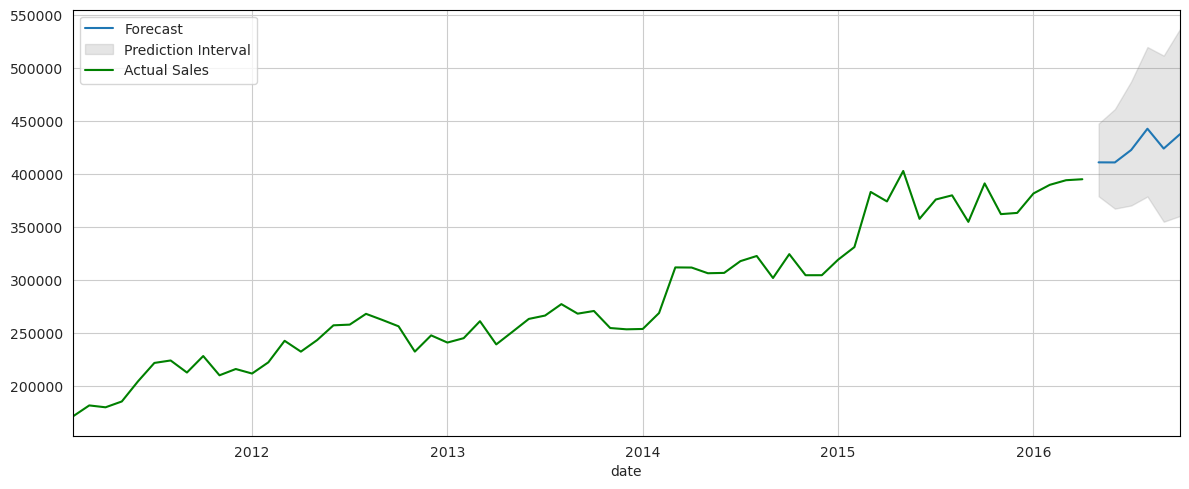

In [170]:
percentile_CA3["97.5th_percentile"]=percentile_CA3["97.5th_percentile"].astype(int)
percentile_CA3["2.5th_percentile"]=percentile_CA3["2.5th_percentile"].astype(int)
fig, ax = plt.subplots(figsize=(12,5),nrows=1,ncols=1)
predicted_CA3.plot(ax=ax, legend=True, label="Forecast" )
ax.fill_between(percentile_CA3.index,y1=percentile_CA3["2.5th_percentile"],y2=percentile_CA3["97.5th_percentile"],label="Prediction Interval", alpha=0.2,color='gray')
CA_monthly["TX_3"].plot(legend=True, label="Actual Sales",color="green", ax=ax);
ax.legend(loc="upper left")
fig.tight_layout()